<h1><center> House Prices Prediction</center></h1>
<center> 22/05/2023 <center>

***
<br>
<br>
<br>
<br>
<br>

<table>
<thead>
<tr>
<th>Student</th>
<th>Student ID</th>
</tr>
</thead>
<tbody>
<tr>
<td>Alexandra Inselmann</td>
<td>s194368</td>
</tr>
<tr>
<td>Else Christine Bache Semb</td>
<td>s194634</td>
</tr>
<tr>
<td>Lukas Jønsson Olsen</td>
<td>s194642</td>
</tr>
<tr>
<td>Anne Kjerstine Desler</td>
<td>s194333</td>
</tr>
</tbody>
</table>

***

## Data preperation
Imports:

In [2]:
import pandas as pd
import numpy as np
import torch
from torch.distributions import constraints
from torch.nn import Parameter
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import linear_model
#import numpyro
#import numpyro.distributions as dist
#from numpyro import handlers
#from numpyro.infer import MCMC, NUTS

import pyro 
import pyro.contrib.gp as gp
import pyro.distributions as dist
from pyro.contrib.gp.models.model import GPModel
from pyro.contrib.gp.util import conditional
from pyro.distributions.util import eye_like
from pyro.nn.module import PyroParam, pyro_method


#import jax
#import jax.numpy as jnp
#from jax import random, vmap
#from jax.scipy.special import logsumexp
#from jax import lax


import itertools
palette = itertools.cycle(sns.color_palette())

warnings.filterwarnings("ignore")

# fix random generator seed (for reproducibility of results)
np.random.seed(42)


### Dataset
The dataset is imported.

In [3]:
df = pd.read_csv('data/train.csv',index_col='Id')
print('Columns in the dataset: ', df.columns)
print('Length of dataset: ',len(df.columns))

Columns in the dataset:  Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',

### Description of Attributes

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

Since there are 78 attributes and the target, we believe that for this analysis it is suitable to exclude many attributes and keep 18 of them. 

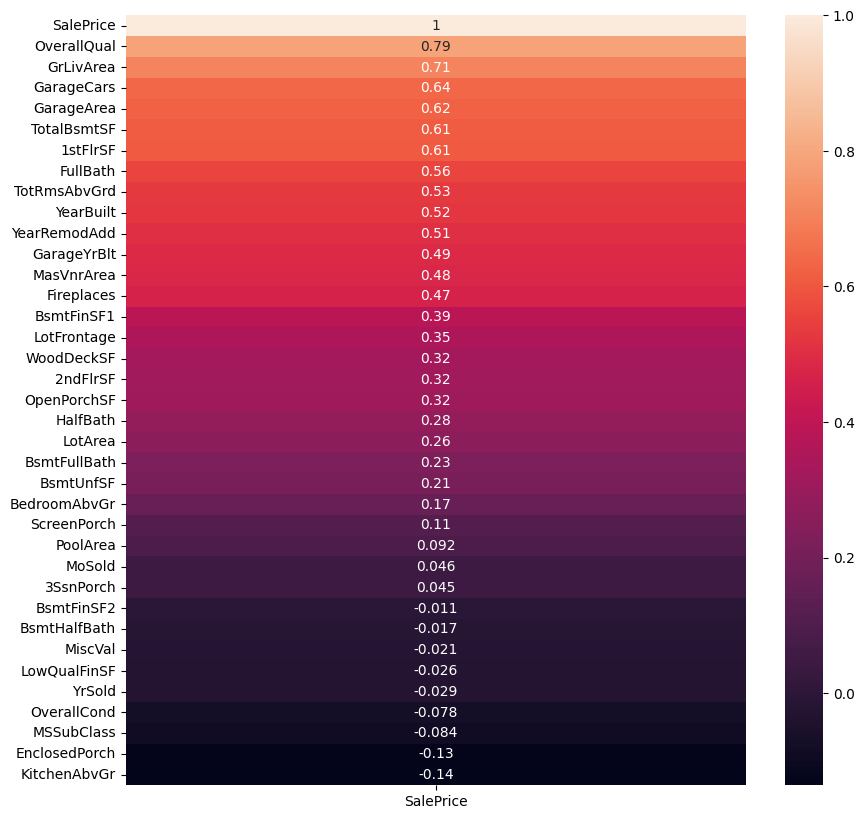

In [5]:
fig = plt.figure(figsize=(10, 10))
corr = df.corr(numeric_only=True)
corrSale = pd.DataFrame(corr['SalePrice'].sort_values(ascending=False))
# plot the heatmap
sns.heatmap(corrSale,annot=True)
fig.savefig('figures/corr.png')

<AxesSubplot: >

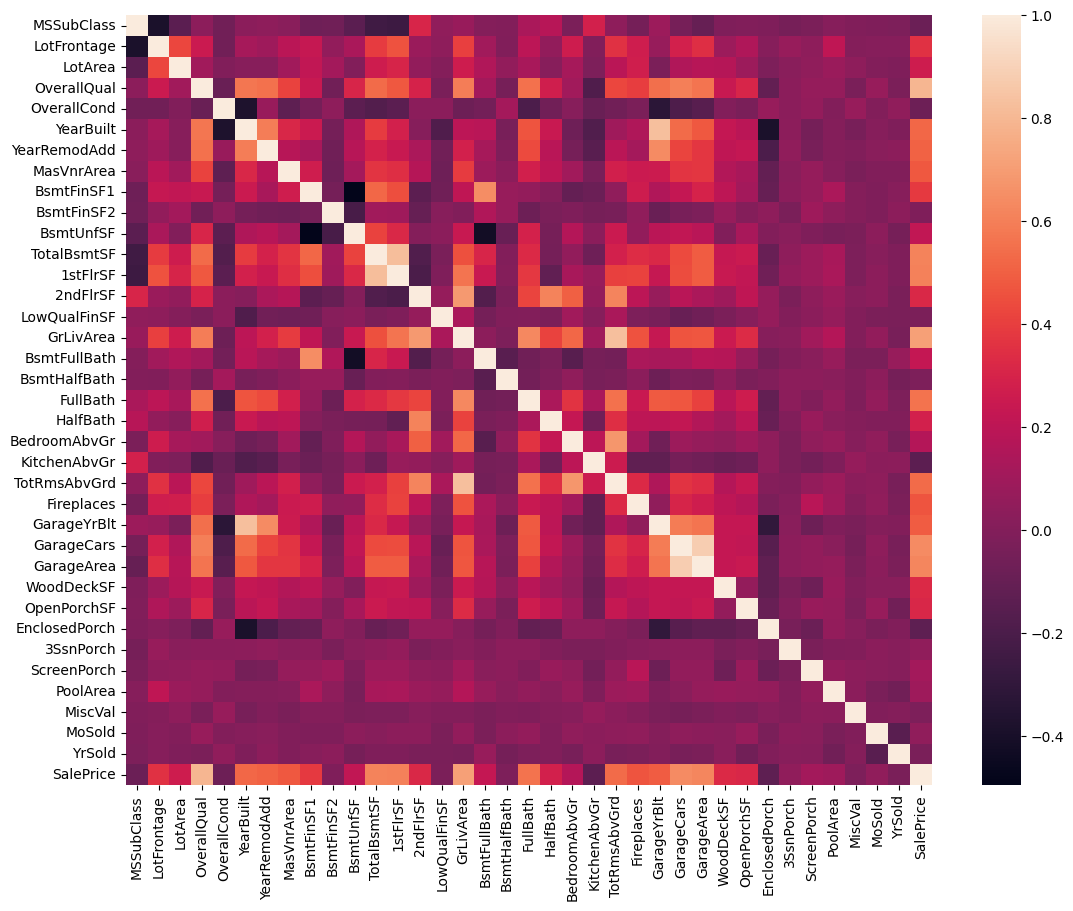

In [6]:
plt.figure(figsize=(13, 10))
# plot the heatmap
sns.heatmap(corr)

To handle attributes the chosen attributes that need proccesing these are saved into a list depending on the attribute type.

In [7]:
target = ['SalePrice']

focus_list = ['OverallQual', 'GrLivArea', 'GarageArea','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
              'YearBuilt','YearRemodAdd','Fireplaces', 'LotArea','YrSold', 'OverallCond','MSZoning',
              'BsmtQual','BsmtCond','HeatingQC','CentralAir','BedroomAbvGr','KitchenQual','Functional']


nominal_list = ['MSZoning']
ordinal_list = ['BsmtQual','BsmtCond','HeatingQC','KitchenQual'] 
df_focus = df[focus_list+target]    



### Data Preperation

Procces the attributes which is nomial and ordinal, and add them to dataframe. The ordinal attributes is factorized in order to get the numeric representation by identifying distinct values. If the attribute has a nan value, we insert 0. For the nomial attributes we create dummy variables. We also create binary variables for CentralAir and for the presence of a basement and a pool.

In [8]:
categories={'N':0,'Y':1}
df_focus['CentralAir'] = df_focus['CentralAir'].map(categories)

categories={'Sal':0,'Sev':1,'Maj2':2,'Maj1':3,'Mod':4,'Min2':5,'Min1':6,'Typ':7}
df_focus['Functional'] = df_focus['Functional'].map(categories)

df_focus['Bath'] = df_focus['BsmtFullBath'] + 0.5*df_focus['BsmtHalfBath'] + df_focus['FullBath'] + 0.5*df_focus['HalfBath']

df_focus = df_focus.drop(['BsmtFullBath','BsmtHalfBath','FullBath','HalfBath'], axis=1)

for attribute in ordinal_list:
    categories={'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5}
    df_focus[attribute] = df_focus[attribute].map(categories)
    df_focus[attribute] = df_focus[attribute].fillna(0)

df_focus = df_focus.dropna()

for attribute in nominal_list:
    df_focus = pd.concat([df_focus,pd.get_dummies(df_focus[attribute], prefix=attribute, dtype=int)]
                            ,axis=1)
    df_focus.pop(attribute)

df_focus['Bsmt'] = df_focus['BsmtQual']!=0
df_focus['Bsmt'] = df_focus['Bsmt'].astype(int)
df_focus['Garage'] = df_focus['GarageArea']!=0
df_focus['Garage'] = df_focus['Garage'].astype(int)

focus_list = ['OverallQual', 'GrLivArea', 'GarageArea','TotalBsmtSF',
              'YearBuilt','YearRemodAdd','Fireplaces', 'LotArea','YrSold', 'OverallCond','MSZoning',
              'BsmtQual','BsmtCond','HeatingQC','CentralAir','BedroomAbvGr','KitchenQual','Functional','Bath','Bsmt','Garage']


print(df_focus.shape)


(1460, 26)


### Descriptive Statistics 

The raw data has been processed and we can look at the descriptive statistics of the attributes:

In [9]:
print("Descriptive Statistics: Training Dataset")
df_focus.describe().T

Descriptive Statistics: Training Dataset


count           mean           std      min        25%  \
OverallQual       1460.0       6.099315      1.382997      1.0       5.00   
GrLivArea         1460.0    1515.463699    525.480383    334.0    1129.50   
GarageArea        1460.0     472.980137    213.804841      0.0     334.50   
TotalBsmtSF       1460.0    1057.429452    438.705324      0.0     795.75   
YearBuilt         1460.0    1971.267808     30.202904   1872.0    1954.00   
YearRemodAdd      1460.0    1984.865753     20.645407   1950.0    1967.00   
Fireplaces        1460.0       0.613014      0.644666      0.0       0.00   
LotArea           1460.0   10516.828082   9981.264932   1300.0    7553.50   
YrSold            1460.0    2007.815753      1.328095   2006.0    2007.00   
OverallCond       1460.0       5.575342      1.112799      1.0       5.00   
BsmtQual          1460.0       3.489041      0.876478      0.0       3.00   
BsmtCond          1460.0       2.934932      0.552159      0.0       3.00   
HeatingQC         1460.0       4.145205      0.959501      1.0       3.00   
CentralAir        1460.0       0.934932      0.246731      0.0       1.00   
BedroomAbvGr      1460.0       2.866438      0.815778      0.0       2.00   
KitchenQual       1460.0       3.511644      0.663760      2.0       3.00   
Functional        1460.0       6.841781      0.667698      1.0       7.00   
SalePrice         1460.0  180921.195890  79442.502883  34900.0  129975.00   
Bath              1460.0       2.210616      0.785399      1.0       2.00   
MSZoning_C (all)  1460.0       0.006849      0.082505      0.0       0.00   
MSZoning_FV       1460.0       0.044521      0.206319      0.0       0.00   
MSZoning_RH       1460.0       0.010959      0.104145      0.0       0.00   
MSZoning_RL       1460.0       0.788356      0.408614      0.0       1.00   
MSZoning_RM       1460.0       0.149315      0.356521      0.0       0.00   
Bsmt              1460.0       0.974658      0.157217      0.0       1.00   
Garage            1460.0       0.944521      0.228992      0.0       1.00   

                       50%        75%       max  
OverallQual            6.0       7.00      10.0  
GrLivArea           1464.0    1776.75    5642.0  
GarageArea           480.0     576.00    1418.0  
TotalBsmtSF          991.5    1298.25    6110.0  
YearBuilt           1973.0    2000.00    2010.0  
YearRemodAdd        1994.0    2004.00    2010.0  
Fireplaces             1.0       1.00       3.0  
LotArea             9478.5   11601.50  215245.0  
YrSold              2008.0    2009.00    2010.0  
OverallCond            5.0       6.00       9.0  
BsmtQual               4.0       4.00       5.0  
BsmtCond               3.0       3.00       4.0  
HeatingQC              5.0       5.00       5.0  
CentralAir             1.0       1.00       1.0  
BedroomAbvGr           3.0       3.00       8.0  
KitchenQual            3.0       4.00       5.0  
Functional             7.0       7.00       7.0  
SalePrice         163000.0  214000.00  755000.0  
Bath                   2.0       2.50       6.0  
MSZoning_C (all)       0.0       0.00       1.0  
MSZoning_FV            0.0       0.00       1.0  
MSZoning_RH            0.0       0.00       1.0  
MSZoning_RL            1.0       1.00       1.0  
MSZoning_RM            0.0       0.00       1.0  
Bsmt                   1.0       1.00       1.0  
Garage                 1.0       1.00       1.0

Histograms are created for each attribute. It can be seen that the target variable, SalePrice, has an exponential curve, but if we take the log tranformation of the SalePrice we get a normal distribution.

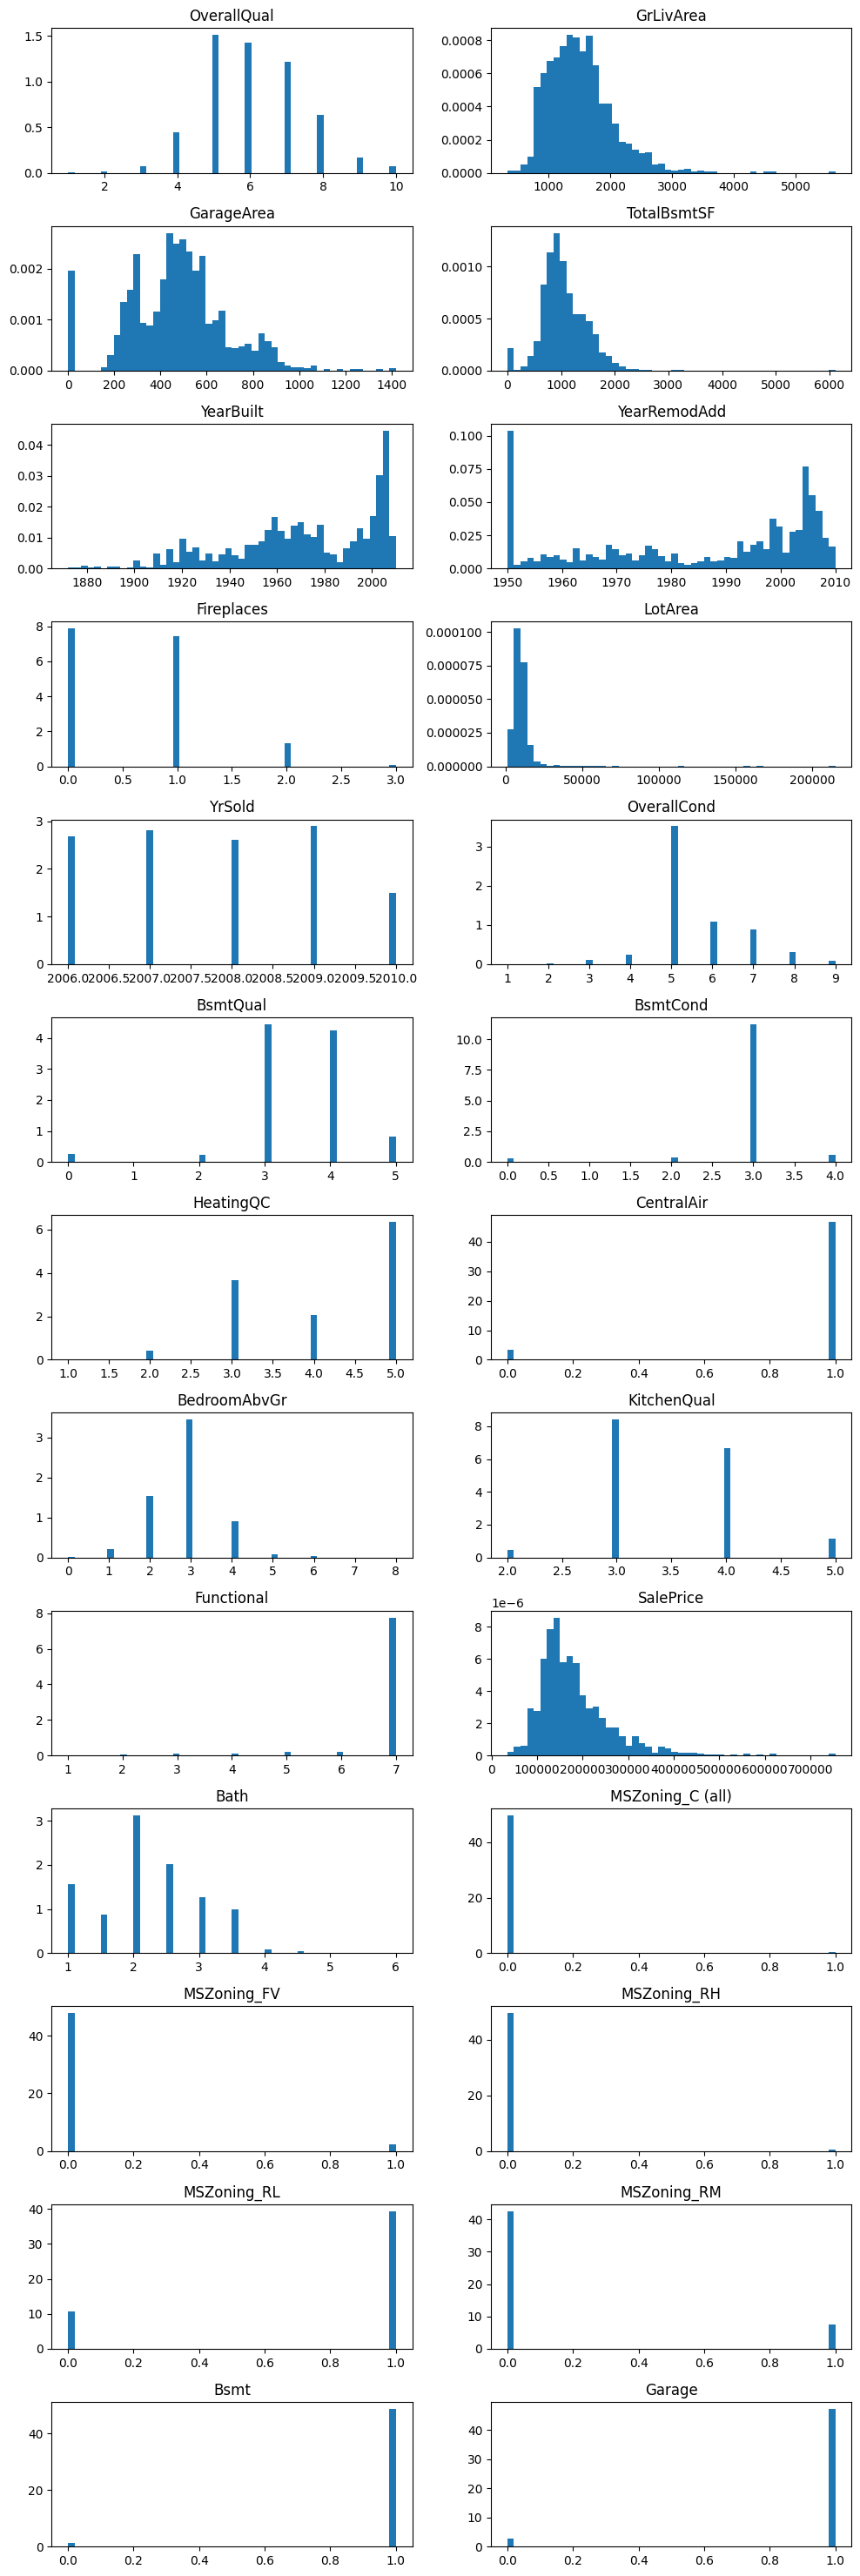

In [10]:
fig = plt.figure(figsize=(10,30))
i = 0
for attribute in df_focus.columns:
    i += 1
    ax = fig.add_subplot(13, 2, i)
    ax.hist(df_focus[attribute],bins=50, density=True)
    ax.set_title(attribute)
fig.tight_layout(rect=[0, 0, 1, 0.99])

We look into the correlation between the attributes

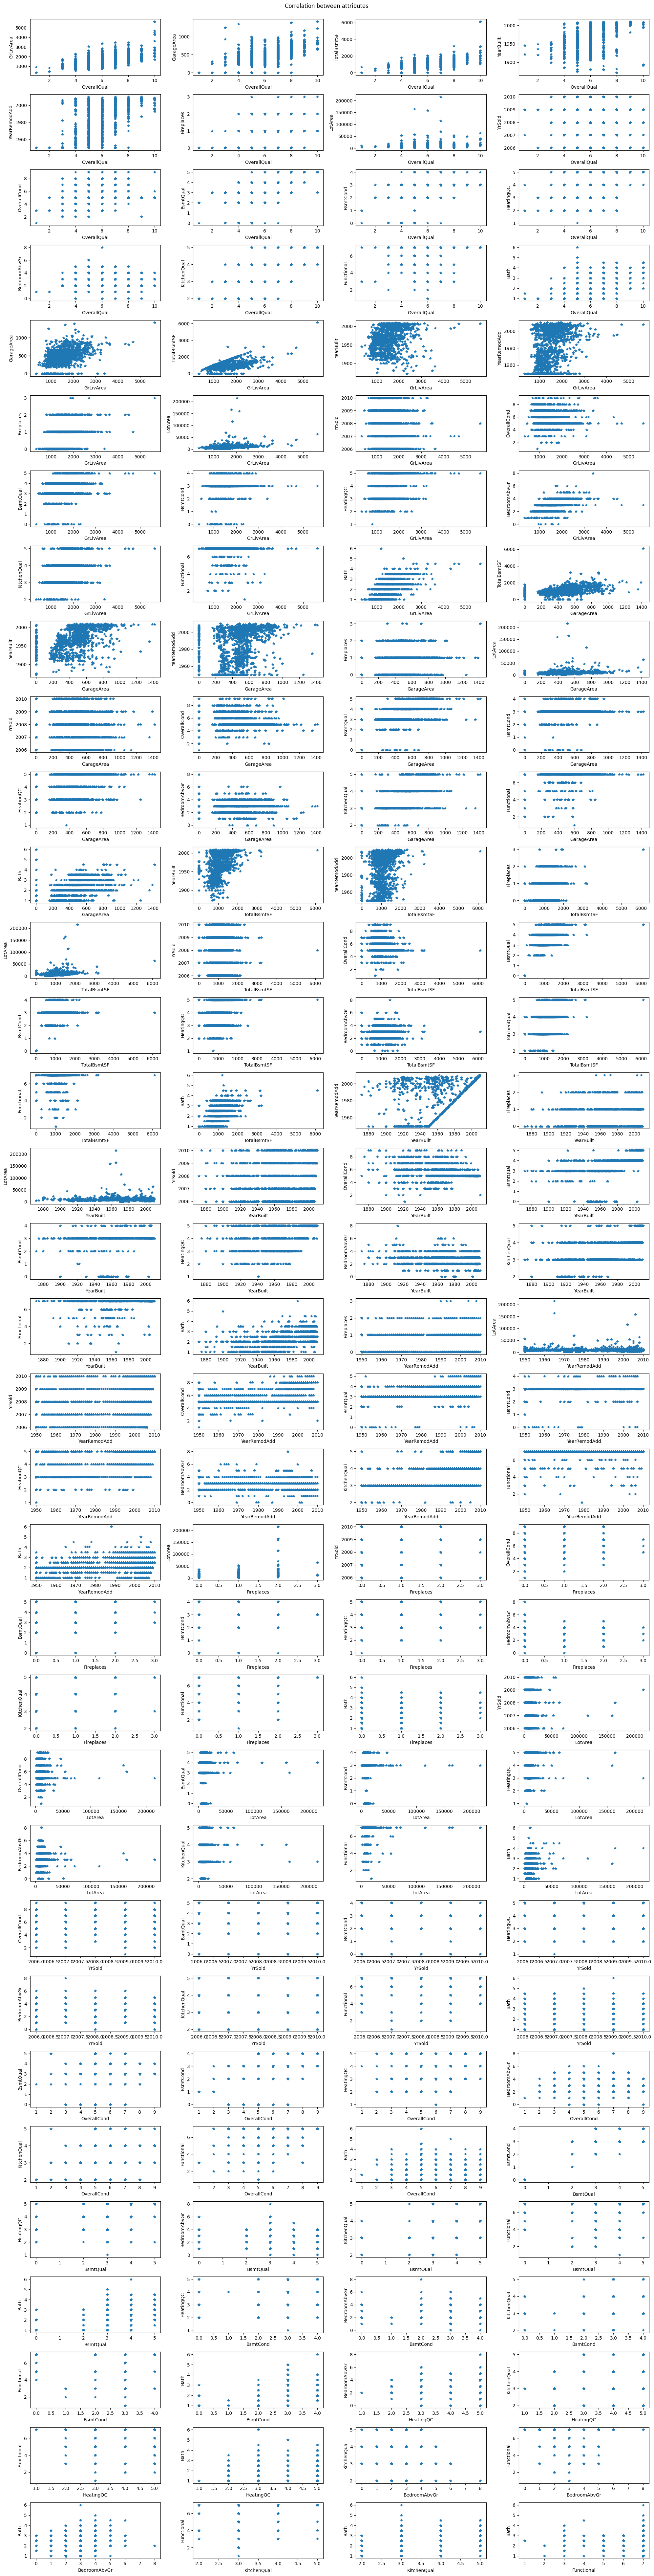

In [11]:
fig = plt.figure(figsize=(20,80))
i = 1
for j, attribute_1 in enumerate(focus_list):
    if j==len(focus_list)-1 or attribute_1 in nominal_list or attribute_1 == 'CentralAir' or attribute_1 == 'Pool' or attribute_1 == 'Bsmt' or attribute_1 == 'Garage':
            continue
    for attribute_2 in (focus_list)[j+1:]:
        if attribute_2 in nominal_list or attribute_2 == 'CentralAir' or attribute_2 == 'Pool' or attribute_2 == 'Bsmt' or attribute_2 == 'Garage':
            continue
        att_1 = df_focus[attribute_1]
        att_2 = df_focus[attribute_2]
        ax = fig.add_subplot(34, 4, i)
        i += 1
        ax.plot(att_1,att_2,'*')
        #ax.set_title(crime_1+"/\n"+crime_2)
        ax.set_xlabel(attribute_1)
        ax.set_ylabel(attribute_2)
fig.suptitle('Correlation between attributes')
fig.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

It is mostly interesting to look the correlation plots between the target variable and the other attributes.

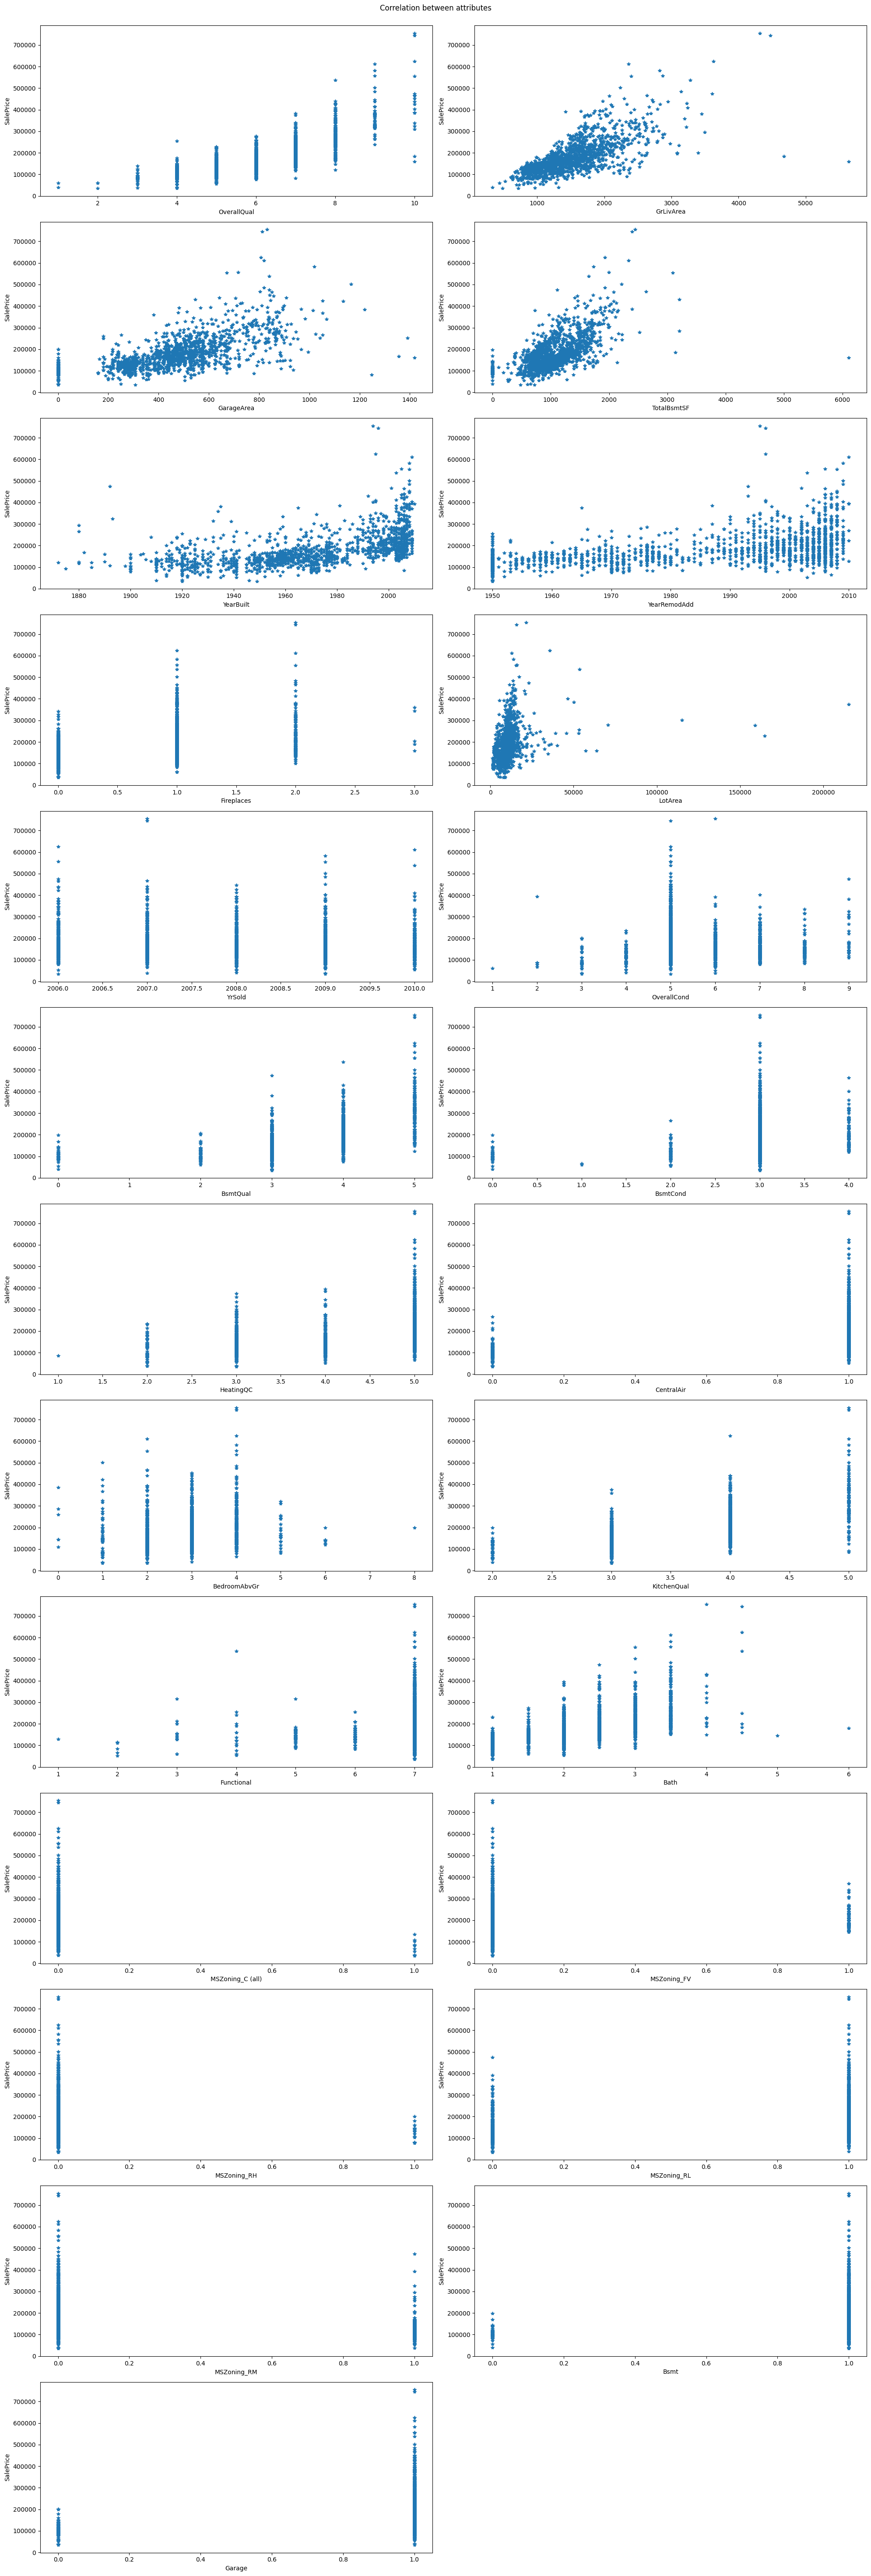

In [12]:
fig = plt.figure(figsize=(20,60))
i = 1
attribute_1 = target[0]
att_1 = df_focus[attribute_1]
for attribute_2 in df_focus.columns:
    if attribute_2 == attribute_1:
        continue

    att_2 = df_focus[attribute_2]
    ax = fig.add_subplot(13, 2, i)
    i += 1
    ax.plot(att_2,att_1,'*')
    ax.set_xlabel(attribute_2)
    ax.set_ylabel(attribute_1)
fig.suptitle('Correlation between attributes')
fig.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

It is clear form the histogram of the target that the SalePrice looks log-normally distributed

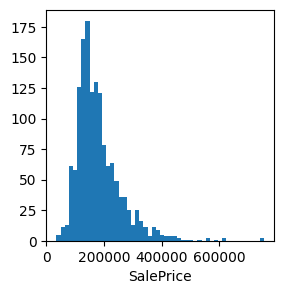

In [13]:
fig = plt.figure(figsize=(10,3))
ax = fig.add_subplot(1, 3, 1)
ax.hist(df_focus['SalePrice'],bins=50)
ax.set_xlabel('SalePrice')
fig.savefig('figures/SalePrice.png',bbox_inches='tight')
plt.show()

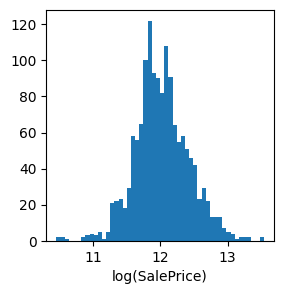

In [14]:
fig = plt.figure(figsize=(10,3))
ax = fig.add_subplot(1, 3, 1)
ax.hist(np.log(df_focus['SalePrice']),bins=50)
ax.set_xlabel('log(SalePrice)')
fig.savefig('figures/log_SalePrice.png',bbox_inches='tight')
plt.show()

We look at the correlation plots again

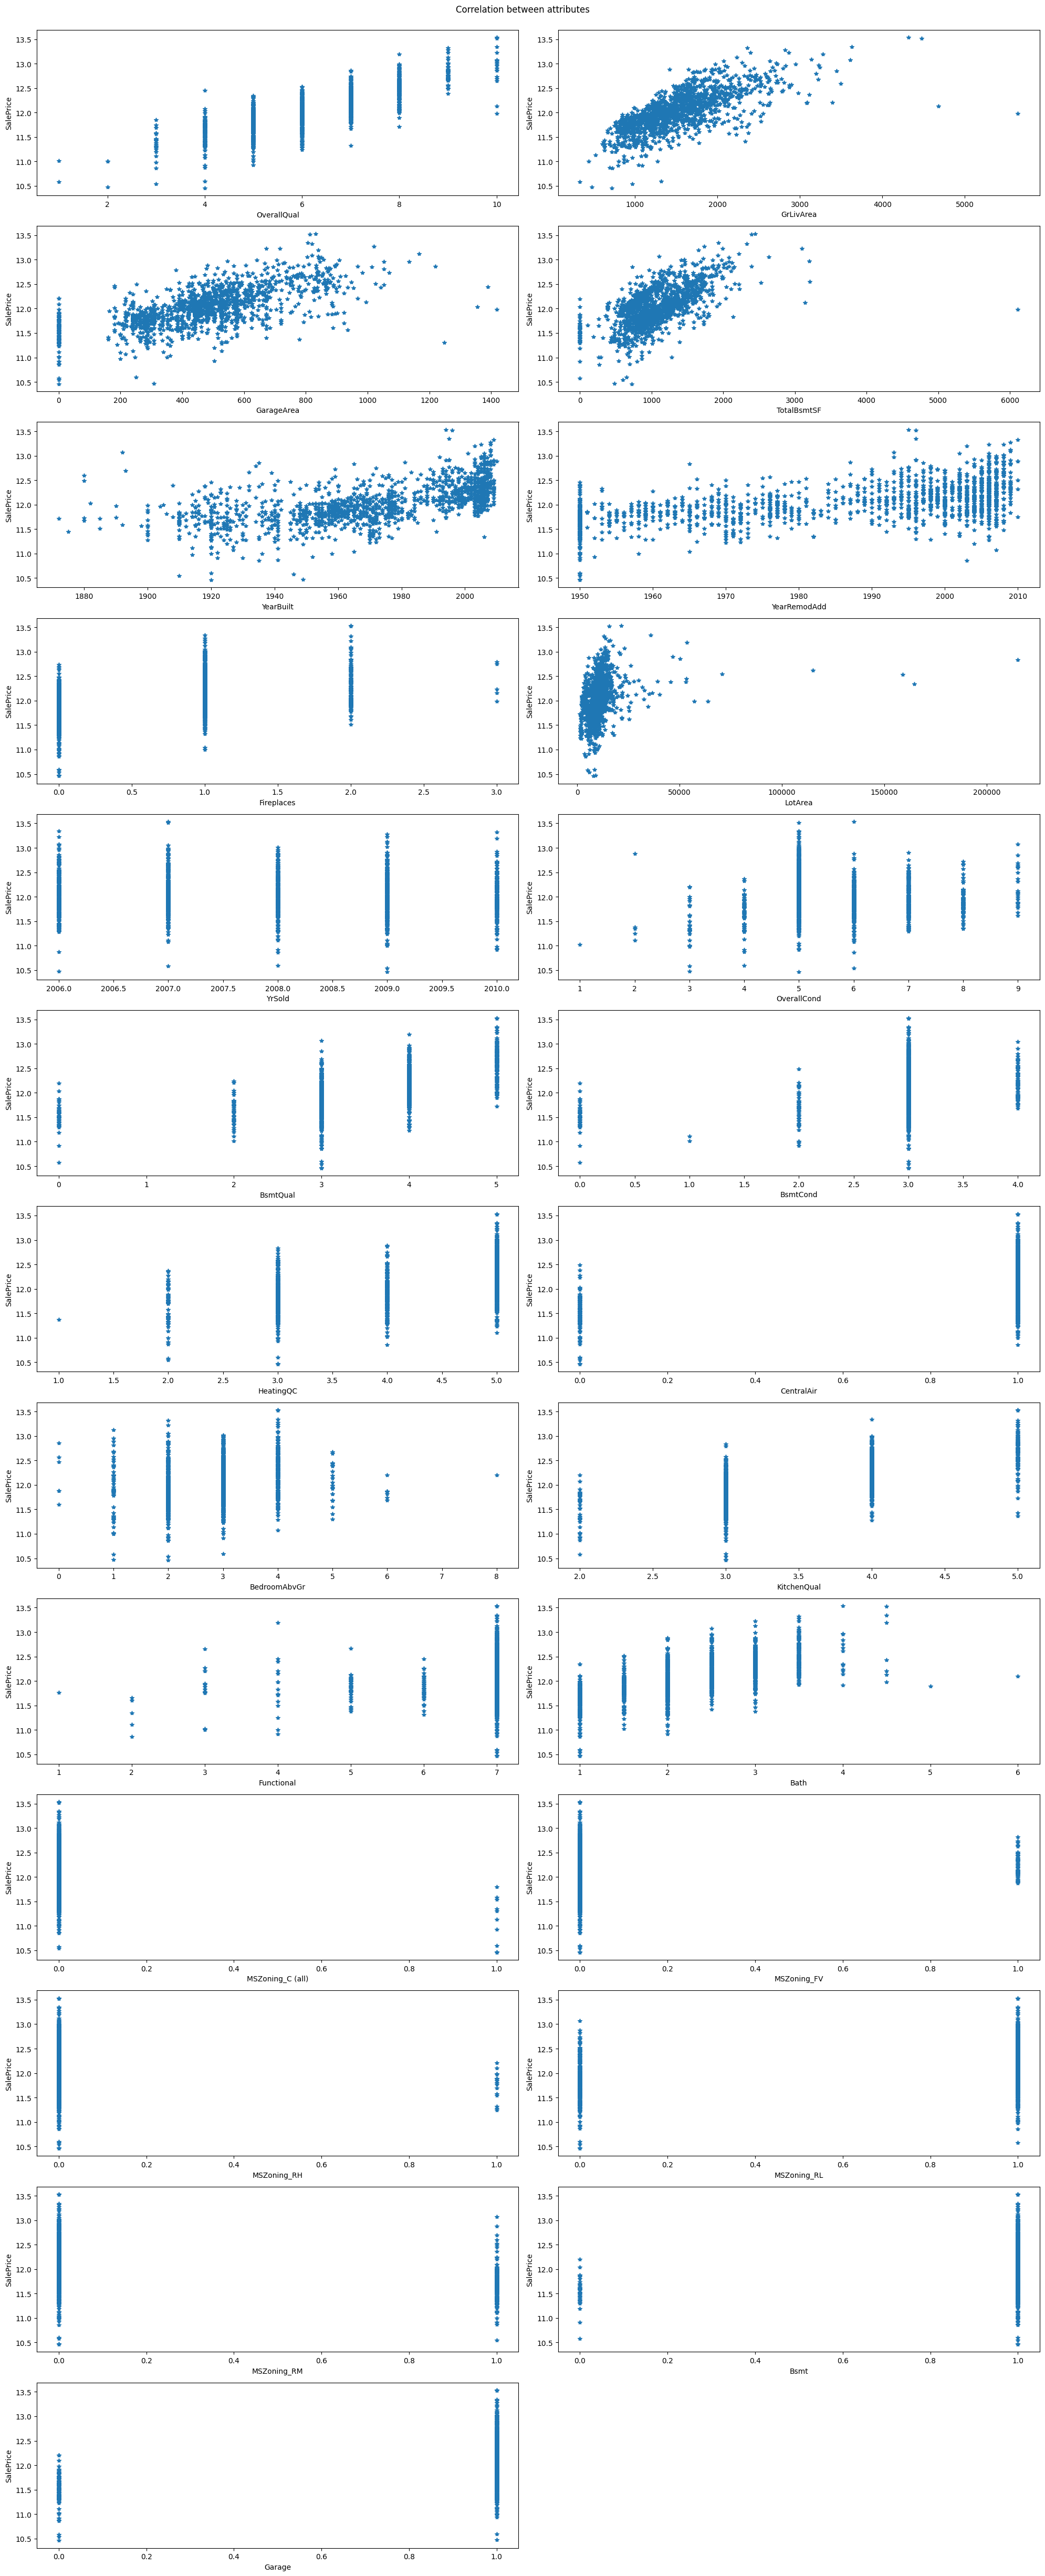

In [15]:
fig = plt.figure(figsize=(20,50))
i = 1
attribute_1 = target[0]
att_1 = np.log(df_focus[attribute_1])
for attribute_2 in df_focus.columns:
    if attribute_2 == attribute_1:
        continue

    att_2 = df_focus[attribute_2]
    ax = fig.add_subplot(13, 2, i)
    i += 1
    ax.plot(att_2,att_1,'*')
    ax.set_xlabel(attribute_2)
    ax.set_ylabel(attribute_1)
fig.suptitle('Correlation between attributes')
fig.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

There are some clear outliers in the data especially in the GrLivArea, TotalBsmtSF and the LotArea. 
## Data preprocessing

We remove the outliers based on thresholding the three attributes: GrLivArea, TotalBsmtSF and the LotArea. 

In [16]:
def remove_outliers(df, attribute, min = None, max = None, include_min = True, include_max = True):
    if min is not None:
        if include_min:
            df = df[df[attribute]>=min]
        else:
            df = df[df[attribute]>min]
    if max is not None:
        if include_max:
            df = df[df[attribute]<=max]
        else:
            df = df[df[attribute]<max]
    return df

In [17]:
df_focus = remove_outliers(df_focus, 'GrLivArea', min = 1, max = 4000, include_min = True, include_max = True)


In [18]:
df_focus = remove_outliers(df_focus, 'TotalBsmtSF', min = None, max = 2000, include_min = True, include_max = False)


In [19]:
df_focus = remove_outliers(df_focus, 'LotArea', min = None, max = 10000, include_min = True, include_max = False)


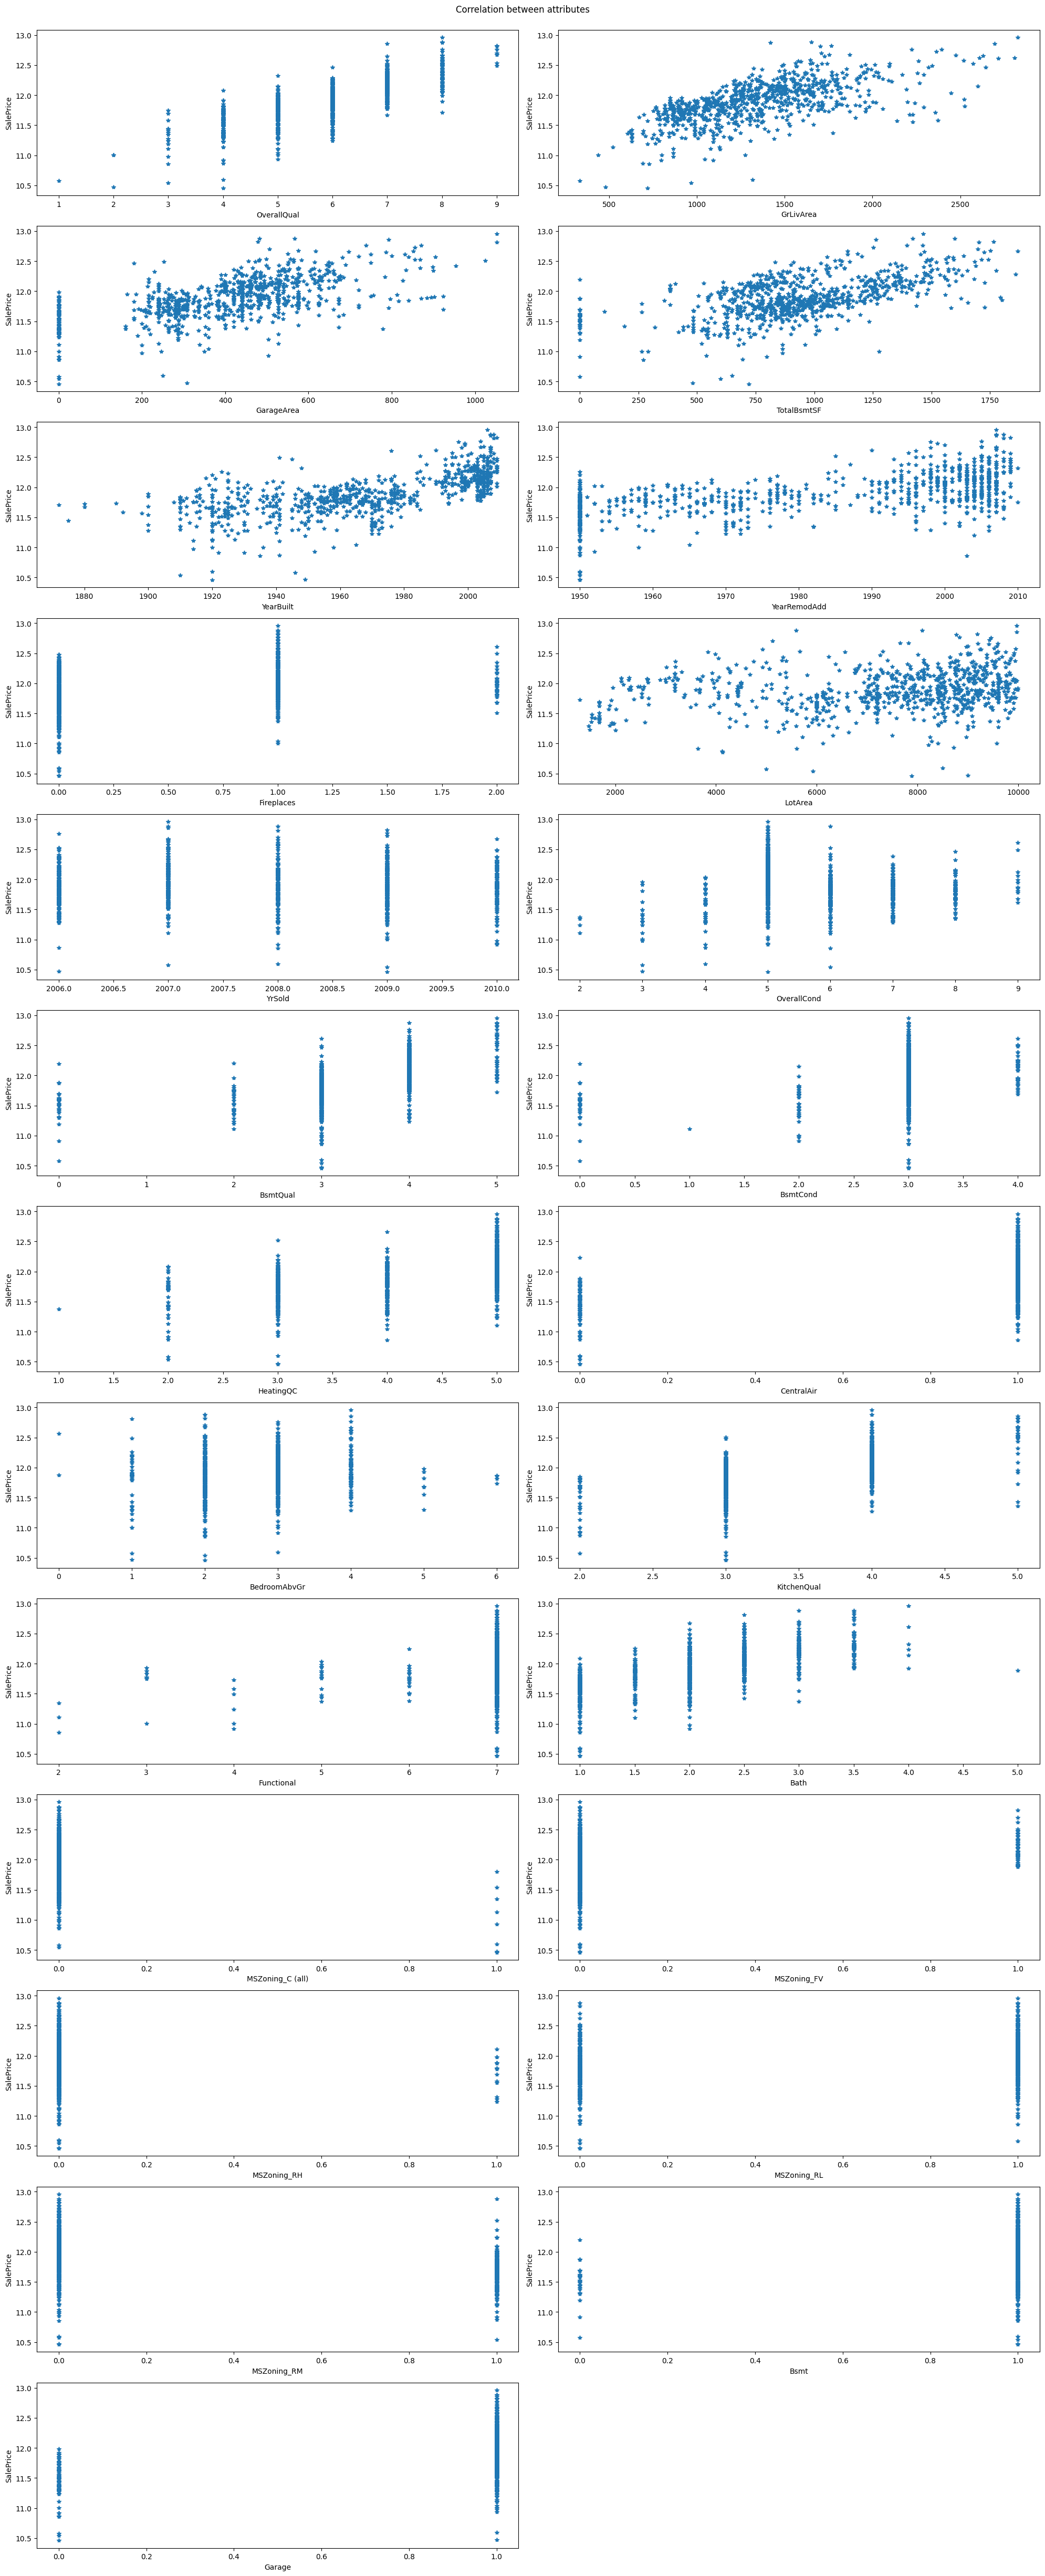

In [20]:
fig = plt.figure(figsize=(20,50))
i = 1
attribute_1 = target[0]
att_1 = np.log(df_focus[attribute_1])
for attribute_2 in df_focus.columns:
    if attribute_2 == attribute_1:
        continue

    att_2 = df_focus[attribute_2]
    ax = fig.add_subplot(13, 2, i)
    i += 1
    ax.plot(att_2,att_1,'*')
    ax.set_xlabel(attribute_2)
    ax.set_ylabel(attribute_1)
fig.suptitle('Correlation between attributes')
fig.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

Finally we split the dataset into a train and a test set, log-transform the target and standardize both the training and the testing set. 

In [21]:
df = df_focus
df[target[0]] = np.log(df[target[0]])
df_train, df_test = train_test_split(df, test_size=0.33)
print(df.columns)

Index(['OverallQual', 'GrLivArea', 'GarageArea', 'TotalBsmtSF', 'YearBuilt',
       'YearRemodAdd', 'Fireplaces', 'LotArea', 'YrSold', 'OverallCond',
       'BsmtQual', 'BsmtCond', 'HeatingQC', 'CentralAir', 'BedroomAbvGr',
       'KitchenQual', 'Functional', 'SalePrice', 'Bath', 'MSZoning_C (all)',
       'MSZoning_FV', 'MSZoning_RH', 'MSZoning_RL', 'MSZoning_RM', 'Bsmt',
       'Garage'],
      dtype='object')


In [22]:
df_train_std = df_train.copy()
df_test_std = df_test.copy()

for attribute in focus_list+target:
    if attribute in nominal_list or attribute == 'CentralAir' or attribute == 'Bsmt' or attribute == 'Garage':
        continue
    
    if attribute in ordinal_list + ['TotalBsmtSF']:
        df_att = df_train[attribute].where(df_train[attribute]!=0)
        att_mean = df_att.mean()
        att_std = df_att.std()
    else:
        att_mean = df_train[attribute].mean()
        att_std = df_train[attribute].std()

    if attribute == target[0]:
        target_mean = att_mean
        target_std = att_std
    df_train_std[attribute] = (df_train[attribute]-att_mean)/att_std
    df_test_std[attribute] = (df_test[attribute]-att_mean)/att_std

target_statistics = np.array([target_mean,target_std])

In [23]:
df_train_y = df_train_std[target]
df_train_X = df_train_std.drop(target,axis=1)
df_test_y = df_test_std[target]
df_test_X = df_test_std.drop(target,axis=1)

We set the Basement and Garage attributes to zero is the no Basement/Garage is precent. Finally we save the data set as numpy.

In [24]:
df_train_X_Bsmts = df_train_X[['BsmtQual', 'BsmtCond', 'TotalBsmtSF']]
df_train_X_Bsmt = df_train_X['Bsmt']
df_train_X_Garages = df_train_X['GarageArea']
df_train_X_Garage = df_train_X['Garage']
df_train_X = df_train_X.drop(['BsmtQual', 'BsmtCond', 'TotalBsmtSF', 'GarageArea', 'Bsmt', 'Garage'],axis=1)

X_train = df_train_X.to_numpy()
X_train_Bsmt = df_train_X_Bsmt.to_numpy().reshape(-1,1)
X_train_Bsmts = df_train_X_Bsmts.to_numpy()*X_train_Bsmt
X_train_Garage = df_train_X_Garage.to_numpy().reshape(-1,1)
X_train_Garages = df_train_X_Garages.to_numpy().reshape(-1,1)*X_train_Garage


y_train = df_train_y.to_numpy()

train_set = np.concatenate((X_train, X_train_Bsmt, X_train_Garage, X_train_Bsmts, X_train_Garages, y_train), axis=1)


df_test_X_Bsmts = df_test_X[['BsmtQual', 'BsmtCond', 'TotalBsmtSF']]
df_test_X_Bsmt = df_test_X['Bsmt']
df_test_X_Garages = df_test_X['GarageArea']
df_test_X_Garage = df_test_X['Garage']

df_test_X = df_test_X.drop(['BsmtQual', 'BsmtCond', 'TotalBsmtSF', 'GarageArea', 'Bsmt', 'Garage'], axis=1)
X_test = df_test_X.to_numpy()
X_test_Bsmt = df_test_X_Bsmt.to_numpy().reshape(-1,1)
X_test_Bsmts = df_test_X_Bsmts.to_numpy()*X_test_Bsmt
X_test_Garage = df_test_X_Garage.to_numpy().reshape(-1,1)
X_test_Garages = df_test_X_Garages.to_numpy().reshape(-1,1)*X_test_Garage

y_test = df_test_y.to_numpy()


test_set = np.concatenate((X_test, X_test_Bsmt, X_test_Garage, X_test_Bsmts, X_test_Garages, y_test), axis=1)


print("num train: %d" % len(y_train))
print("num test: %d" % len(y_test))


num train: 560
num test: 276


In [25]:
attribute_names = pd.DataFrame(list(df_train_X.columns) +['Bsmt','Garage','BsmtQual', 'BsmtCond', 'TotalBsmtSF', 'GarageArea', 'SalePrice'])
print(attribute_names)

                   0
0        OverallQual
1          GrLivArea
2          YearBuilt
3       YearRemodAdd
4         Fireplaces
5            LotArea
6             YrSold
7        OverallCond
8          HeatingQC
9         CentralAir
10      BedroomAbvGr
11       KitchenQual
12        Functional
13              Bath
14  MSZoning_C (all)
15       MSZoning_FV
16       MSZoning_RH
17       MSZoning_RL
18       MSZoning_RM
19              Bsmt
20            Garage
21          BsmtQual
22          BsmtCond
23       TotalBsmtSF
24        GarageArea
25         SalePrice


In [26]:
np.save('data/train_processed.npy', train_set)
np.save('data/test_processed.npy', test_set)
np.save('data/target_statistics.npy',target_statistics)

In [27]:
train_df = pd.DataFrame(train_set) 
test_df = pd.DataFrame(test_set) 
train_df.to_csv('data/train_processed.csv', index=False)  
test_df.to_csv('data/test_processed.csv', index=False)
attribute_names.to_csv('data/attribute_names.csv', index=False)

## Modelling
We define functions for calculating the error metrics and for transforming the data back to the original domain.

In [48]:
def compute_error(trues, predicted, include_outliers=True):
    if not include_outliers:
        n = len(trues)
        diff = np.abs(trues - predicted)
        idx = np.argsort(diff, axis=0)
        idx = idx.reshape(-1)
        idx = idx[:int(n*0.95)]
        trues = trues[idx]
        predicted = predicted[idx]

    corr = np.corrcoef(predicted, trues)[0,1]
    mae = np.mean(np.abs(predicted - trues))
    rae = np.sum(np.abs(predicted - trues)) / np.sum(np.abs(trues - np.mean(trues)))
    rmse = np.sqrt(np.mean((predicted - trues)**2))
    r2 = max(0, 1 - np.sum((trues-predicted)**2) / np.sum((trues - np.mean(trues))**2))
    return corr, mae, rae, rmse, r2

def transform(y, mean, std):
    return np.exp(y * std + mean)

y_std = target_statistics[1]
y_mean = target_statistics[0]


Load data:

In [49]:
train_set = np.load('data/train_processed.npy')
test_set = np.load('data/test_processed.npy')
target_statistics = np.load('data/target_statistics.npy')
attribute_names = pd.read_csv('data/attribute_names.csv')

X_train = train_set[:,:-1]
y_train = train_set[:,-1:]
X_test = test_set[:,:-1]
y_test = test_set[:,-1:]

### Ridge Regression
We fit the ridge regression model with the training data.

In [78]:
#regr = linear_model.LinearRegression()
regr = linear_model.Ridge(fit_intercept=True)
regr.fit(X_train, y_train)
print('Intercept %.3f' % (regr.intercept_[0]))
for i, name in enumerate(attribute_names['0'][:-1]):
    print(name,"%.3f" % (regr.coef_[0][i]))



Intercept -1.202
OverallQual 0.197
GrLivArea 0.276
YearBuilt 0.152
YearRemodAdd 0.035
Fireplaces 0.052
LotArea 0.080
YrSold -0.018
OverallCond 0.127
HeatingQC 0.064
CentralAir 0.247
BedroomAbvGr -0.009
KitchenQual 0.029
Functional 0.068
Bath 0.093
MSZoning_C (all) -1.184
MSZoning_FV 0.440
MSZoning_RH 0.271
MSZoning_RL 0.318
MSZoning_RM 0.155
Bsmt 0.353
Garage 0.373
BsmtQual 0.069
BsmtCond 0.018
TotalBsmtSF 0.152
GarageArea 0.094


#### Evaluate model on test set

In [79]:
y_hat = regr.predict(X_test)

preds = y_hat[:,0]
y_true = y_test[:,0]

target_true = transform(y_true, y_mean, y_std)
target_preds = transform(preds, y_mean, y_std)

corr, mae, rae, rmse, r2 = compute_error(target_true, target_preds)
print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, r2))

corr, mae, rae, rmse, r2 = compute_error(target_true, target_preds, include_outliers=False)
print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, r2))

CorrCoef: 0.930
MAE: 13620.017
RMSE: 21370.112
R2: 0.864
CorrCoef: 0.963
MAE: 11099.312
RMSE: 14021.733
R2: 0.928


Plot predictions vs true

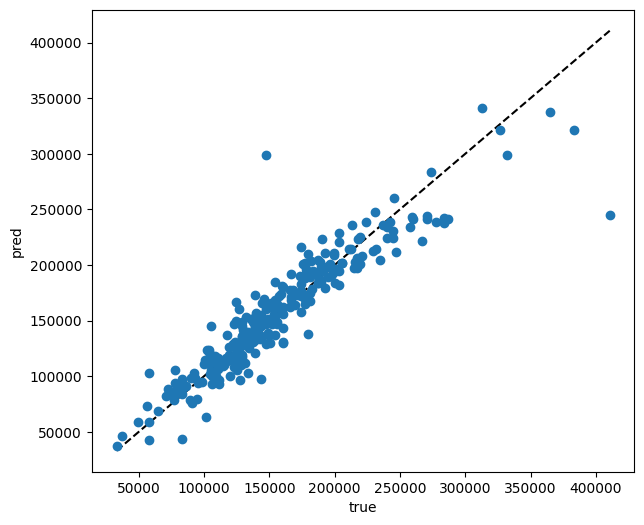

In [80]:
xs = np.linspace(target_true.min(), target_true.max(), 10)
fig = plt.figure(figsize=(7, 6))
plt.plot(xs, xs, 'k--')
plt.plot(target_true, target_preds, 'o')
plt.xlabel('true')
plt.ylabel('pred')
plt.show()
fig.savefig('figures/Ridge_regression_test_org.png', bbox_inches='tight')

#### Evaluate model on training set

In [81]:
y_hat = regr.predict(X_train)

preds = y_hat[:,0]
y_true = y_train[:,0]

target_true = transform(y_true, y_mean, y_std)
target_preds = transform(preds, y_mean, y_std)

corr, mae, rae, rmse, r2 = compute_error(target_true, target_preds)
print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, r2))

corr, mae, rae, rmse, r2 = compute_error(target_true, target_preds, include_outliers=False)
print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, r2))

CorrCoef: 0.953
MAE: 11856.337
RMSE: 17299.914
R2: 0.907
CorrCoef: 0.966
MAE: 9848.429
RMSE: 12375.051
R2: 0.932


Plot predictions vs true

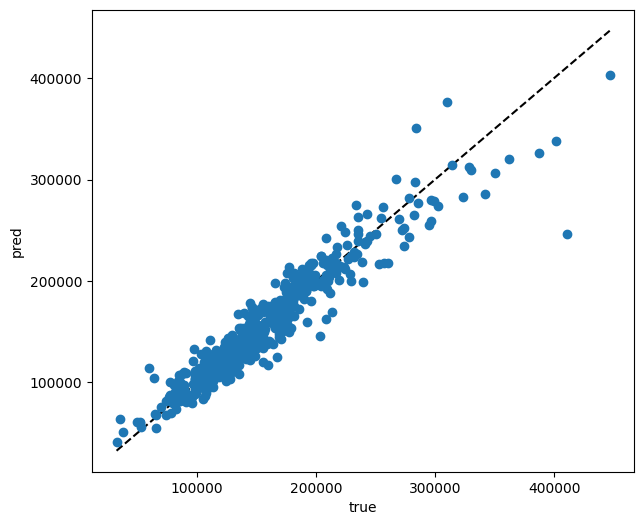

In [82]:
xs = np.linspace(target_true.min(), target_true.max(), 10)
fig = plt.figure(figsize=(7, 6))
plt.plot(xs, xs, 'k--')
plt.plot(target_true, target_preds, 'o')
plt.xlabel('true')
plt.ylabel('pred')
plt.show()
fig.savefig('figures/Ridge_regression_train_org.png', bbox_inches='tight')

### Bayesian Linear Regression
We fit the Bayesian linear regression model with the training data.

In [83]:
def model(X, obs=None):
    X = jnp.asarray(X)
    alpha = numpyro.sample("alpha", dist.Normal(0., 1.))                   # Prior for the bias/intercept
    beta  = numpyro.sample("beta", dist.Normal(jnp.zeros(X.shape[1]), 
                                            jnp.ones(X.shape[1])).to_event())    # Priors for the regression coeffcients
    sigma = numpyro.sample("sigma", dist.HalfNormal(5.))                   # Prior for the variance
    
    mu = alpha + X.dot(beta)
    
    with numpyro.plate("data",len(mu)):
        y = numpyro.sample("y", dist.Normal(mu, sigma), obs=obs)
        
    return y

In [84]:
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

# Run inference in Pyro
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=5000, num_warmup=5000)
mcmc.run(rng_key_, X=X_train, obs=y_train[:,0])

# Extract samples from posterior
posterior_samples = mcmc.get_samples()

# Show summary of inference results
mcmc.print_summary()

sample: 100%|██████████| 10000/10000 [00:28<00:00, 348.96it/s, 127 steps of size 2.60e-02. acc. prob=0.92]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha     -1.05      0.41     -1.06     -1.70     -0.37   1164.39      1.00
   beta[0]      0.19      0.02      0.19      0.16      0.23   4335.16      1.00
   beta[1]      0.28      0.02      0.28      0.24      0.32   2841.86      1.00
   beta[2]      0.15      0.03      0.15      0.11      0.20   2245.06      1.00
   beta[3]      0.03      0.02      0.03     -0.00      0.07   3588.58      1.00
   beta[4]      0.05      0.02      0.05      0.03      0.08   4982.94      1.00
   beta[5]      0.08      0.02      0.08      0.05      0.11   5492.52      1.00
   beta[6]     -0.02      0.01     -0.02     -0.04      0.01   4846.05      1.00
   beta[7]      0.13      0.02      0.13      0.10      0.16   3291.78      1.00
   beta[8]      0.06      0.02      0.06      0.04      0.09   5372.72      1.00
   beta[9]      0.23      0.06      0.23      0.14      0.33   3878.08      1.00
  beta[10]     -0.01      0

#### Histograms of model parameters

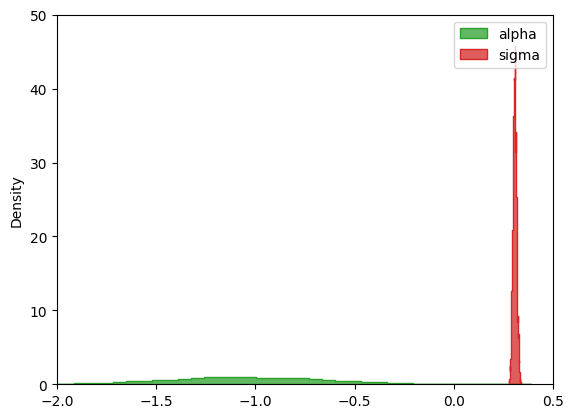

In [85]:
# Alternate plotting due to deprecated distplot-function
sns.histplot(data=posterior_samples["alpha"], stat='density', color=next(palette), element="step")
sns.histplot(data=posterior_samples["sigma"], stat='density', color=next(palette), element="step")
plt.legend(["alpha", "sigma"])
plt.axis([-2,0.5,0,50])
plt.show()

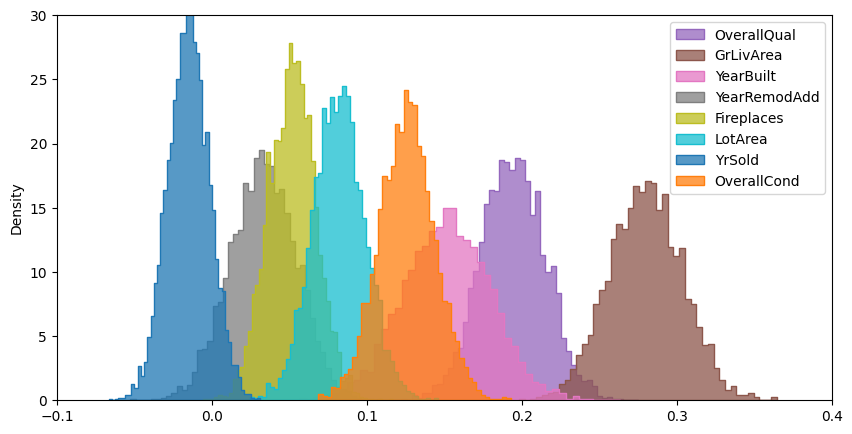

In [86]:
plt.figure(figsize=(10,5))
for i in range(8):
    sns.histplot(posterior_samples["beta"][:,i], color=next(palette), stat='density', element='step')

plt.legend([attribute for attribute in attribute_names['0'][:8]])
plt.axis([-0.1,0.4,0,30])
plt.show()

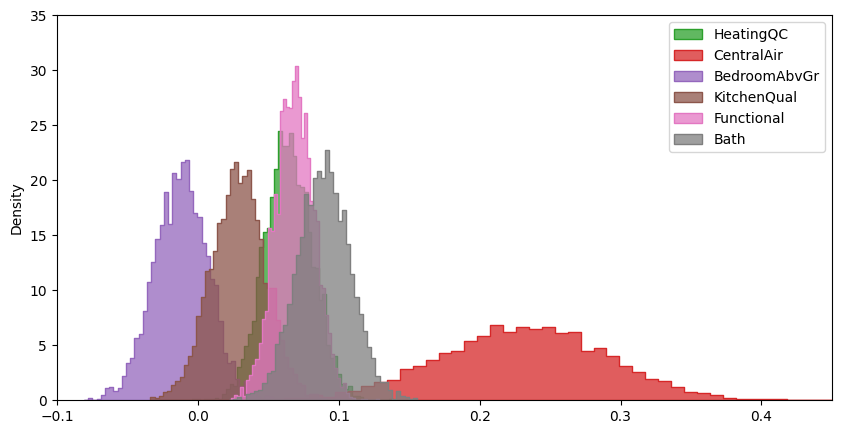

In [87]:
plt.figure(figsize=(10,5))
for i in range(8, 14):
    #sns.distplot(posterior_samples["beta"][:,i])

    # Alternative to avoid warnings
    sns.histplot(posterior_samples["beta"][:,i], color=next(palette), stat='density', element='step')

plt.legend([attribute for attribute in attribute_names['0'][8:14]])
plt.axis([-0.10,0.45,0,35])
plt.show()

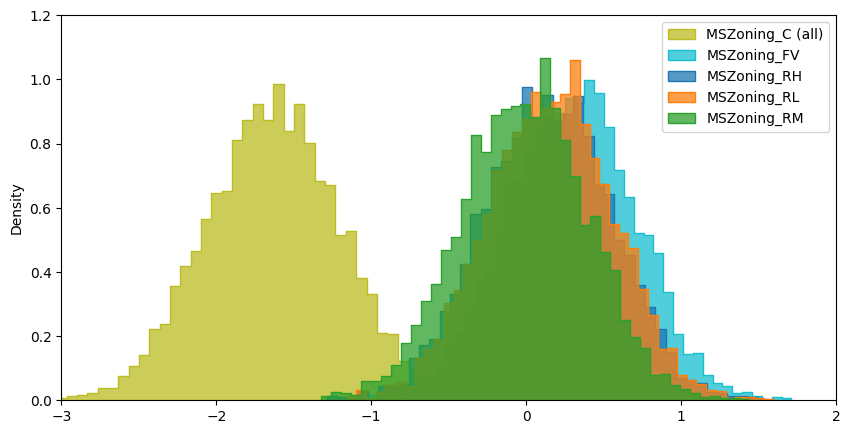

In [89]:
plt.figure(figsize=(10,5))
for i in range(14, 19):
    #sns.distplot(posterior_samples["beta"][:,i])

    # Alternative to avoid warnings
    sns.histplot(posterior_samples["beta"][:,i], color=next(palette), stat='density', element='step')

plt.legend([attribute for attribute in attribute_names['0'][14:19]])
plt.axis([-3,2,0,1.2])
plt.show()

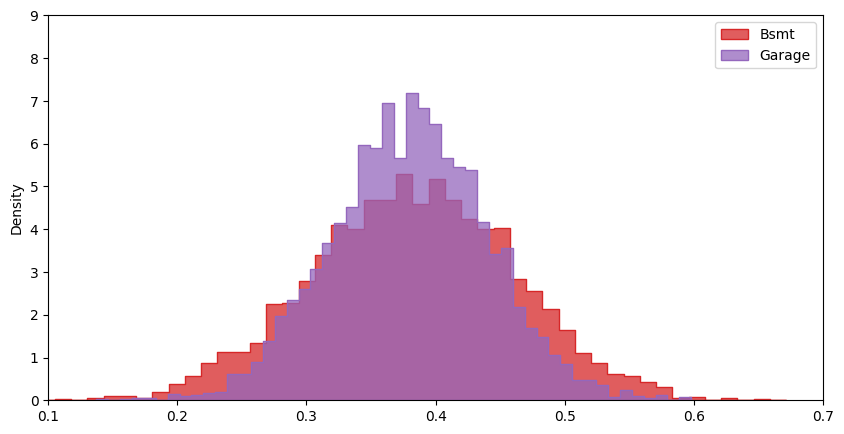

In [90]:
plt.figure(figsize=(10,5))
for i in range(19,21):
    sns.histplot(posterior_samples["beta"][:,i], color=next(palette), stat='density', element='step')
plt.legend([attribute for attribute in attribute_names['0'][19:21]])
plt.axis([0.1,0.7,0,9])
plt.show()

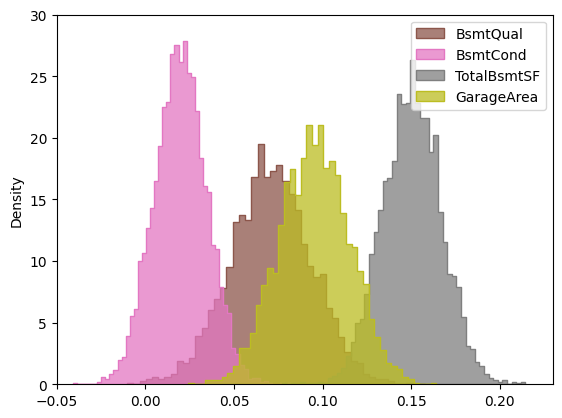

In [91]:
for i in range(21,25):
    sns.histplot(posterior_samples["beta"][:,i], color=next(palette), stat='density', element='step')

plt.legend([attribute for attribute in attribute_names['0'][21:-1]])
plt.axis([-0.05,0.23,0,30])
plt.show()

#### Evaluate model on test set

In [92]:
def predict(X, posterior_samples):
    
    alpha=posterior_samples["alpha"]
    beta=posterior_samples["beta"]

    y_hat = np.mean(alpha[:,np.newaxis] + beta@X.T, axis=0)
    
    return y_hat

In [93]:
preds = predict(X_test, posterior_samples)
y_true = y_test[:,0] 

target_true = transform(y_true, y_mean, y_std)
target_preds = transform(preds, y_mean, y_std)

corr, mae, rae, rmse, r2 = compute_error(target_true, target_preds)
print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, r2))

corr, mae, rae, rmse, r2 = compute_error(target_true, target_preds, include_outliers=False)
print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, r2))

CorrCoef: 0.928
MAE: 13697.714
RMSE: 21534.899
R2: 0.862
CorrCoef: 0.963
MAE: 11141.024
RMSE: 14127.358
R2: 0.928


Plot predictions vs true

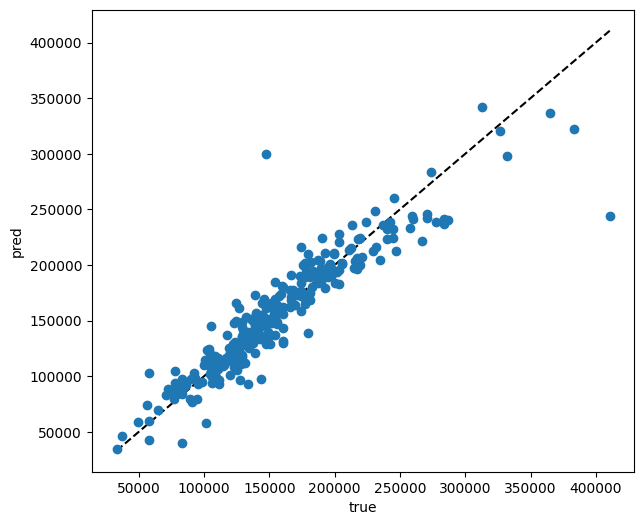

In [94]:
xs = np.linspace(target_true.min(), target_true.max(), 10)

fig = plt.figure(figsize=(7,6))
plt.plot(xs, xs, 'k--')
plt.plot(target_true, target_preds, 'o')
plt.xlabel('true')
plt.ylabel('pred')
plt.show()

fig.savefig('figures/Baysian_Regression_test_org.png')

#### Evaluate model on training set

In [95]:
preds = predict(X_train, posterior_samples)
y_true = y_train[:,0]

target_true = transform(y_true, y_mean, y_std)
target_preds = transform(preds, y_mean, y_std)

corr, mae, rae, rmse, r2 = compute_error(target_true, target_preds)
print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, r2))

corr, mae, rae, rmse, r2 = compute_error(target_true, target_preds, include_outliers=False)
print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, r2))

CorrCoef: 0.953
MAE: 11841.594
RMSE: 17286.406
R2: 0.907
CorrCoef: 0.966
MAE: 9836.488
RMSE: 12351.287
R2: 0.932


Plot predictions vs true

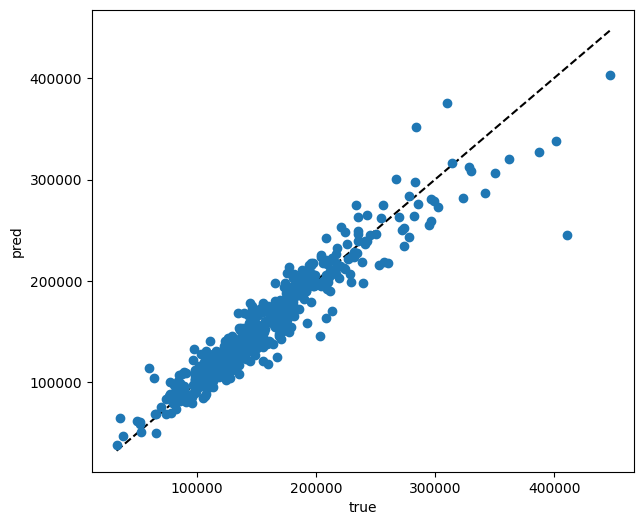

In [96]:
xs = np.linspace(target_true.min(), target_true.max(), 10)

fig = plt.figure(figsize=(7,6))
plt.plot(xs, xs, 'k--')
plt.plot(target_true, target_preds, 'o')
plt.xlabel('true')
plt.ylabel('pred')
plt.show()

fig.savefig('figures/Baysian_Regression_train_org.png')


### Gaussian process regression
Firsly some helper functions is  defined. The VariationalGP class is from exercieses week 12. Plot functionen er inspireret herfra. 

In [50]:
# Convert to tensor
X_train_t,y_train_t  = torch.from_numpy(X_train), torch.from_numpy(y_train)[:,0]
X_test_t, y_test_t = torch.from_numpy(X_test), torch.from_numpy(y_test)[:,0]


In [51]:
class VariationalGP(GPModel):
    r"""
    Variational Gaussian Process model.
    This model deals with both Gaussian and non-Gaussian likelihoods. Given inputs\
    :math:`X` and their noisy observations :math:`y`, the model takes the form
    .. math::
        f &\sim \mathcal{GP}(0, k(X, X)),\\
        y & \sim p(y) = p(y \mid f) p(f),
    where :math:`p(y \mid f)` is the likelihood.
    We will use a variational approach in this model by approximating :math:`q(f)` to
    the posterior :math:`p(f\mid y)`. Precisely, :math:`q(f)` will be a multivariate
    normal distribution with two parameters ``f_loc`` and ``f_scale_tril``, which will
    be learned during a variational inference process.
    .. note:: This model can be seen as a special version of
        :class:`.SparseVariationalGP` model with :math:`X_u = X`.
    .. note:: This model has :math:`\mathcal{O}(N^3)` complexity for training,
        :math:`\mathcal{O}(N^3)` complexity for testing. Here, :math:`N` is the number
        of train inputs. Size of variational parameters is :math:`\mathcal{O}(N^2)`.
    :param torch.Tensor X: A input data for training. Its first dimension is the number
        of data points.
    :param torch.Tensor y: An output data for training. Its last dimension is the
        number of data points.
    :param ~pyro.contrib.gp.kernels.kernel.Kernel kernel: A Pyro kernel object, which
        is the covariance function :math:`k`.
    :param ~pyro.contrib.gp.likelihoods.likelihood Likelihood likelihood: A likelihood
        object.
    :param callable mean_function: An optional mean function :math:`m` of this Gaussian
        process. By default, we use zero mean.
    :param torch.Size latent_shape: Shape for latent processes (`batch_shape` of
        :math:`q(f)`). By default, it equals to output batch shape ``y.shape[:-1]``.
        For the multi-class classification problems, ``latent_shape[-1]`` should
        corresponse to the number of classes.
    :param bool whiten: A flag to tell if variational parameters ``f_loc`` and
        ``f_scale_tril`` are transformed by the inverse of ``Lff``, where ``Lff`` is
        the lower triangular decomposition of :math:`kernel(X, X)`. Enable this flag
        will help optimization.
    :param float jitter: A small positive term which is added into the diagonal part of
        a covariance matrix to help stablize its Cholesky decomposition.
    """
    def __init__(self, X, y, kernel, likelihood, mean_function=None,
                 latent_shape=None, whiten=False, jitter=1e-6):
        super().__init__(X, y, kernel, mean_function, jitter)

        self.likelihood = likelihood

        y_batch_shape = self.y.shape[:-1] if self.y is not None else torch.Size([])
        self.latent_shape = latent_shape if latent_shape is not None else y_batch_shape

        N = self.X.size(0)
        f_loc = self.X.new_zeros(self.latent_shape + (N,))
        self.f_loc = Parameter(f_loc)

        identity = eye_like(self.X, N)
        f_scale_tril = identity.repeat(self.latent_shape + (1, 1))
        self.f_scale_tril = PyroParam(f_scale_tril, constraints.lower_cholesky)

        self.whiten = whiten
        self._sample_latent = True

    @pyro_method
    def model(self):
        self.set_mode("model")

        N = self.X.size(0)
        Kff = self.kernel(self.X).contiguous()
        Kff.view(-1)[::N + 1] += self.jitter  # add jitter to the diagonal
        Lff = Kff.cholesky()

        zero_loc = self.X.new_zeros(self.f_loc.shape)
        if self.whiten:
            identity = eye_like(self.X, N)
            pyro.sample(self._pyro_get_fullname("f"),
                        dist.MultivariateNormal(zero_loc, scale_tril=identity)
                            .to_event(zero_loc.dim() - 1))
            f_scale_tril = Lff.matmul(self.f_scale_tril)
            f_loc = Lff.matmul(self.f_loc.unsqueeze(-1)).squeeze(-1)
        else:
            pyro.sample(self._pyro_get_fullname("f"),
                        dist.MultivariateNormal(zero_loc, scale_tril=Lff)
                            .to_event(zero_loc.dim() - 1))
            f_scale_tril = self.f_scale_tril
            f_loc = self.f_loc

        f_loc = f_loc + self.mean_function(self.X)
        f_var = f_scale_tril.pow(2).sum(dim=-1)
        if self.y is None:
            return f_loc, f_var
        else:
            return self.likelihood(f_loc, f_var, self.y)

    @pyro_method
    def guide(self):
        self.set_mode("guide")
        self._load_pyro_samples()

        pyro.sample(self._pyro_get_fullname("f"),
                    dist.MultivariateNormal(self.f_loc, scale_tril=self.f_scale_tril)
                        .to_event(self.f_loc.dim()-1))

    def forward(self, Xnew, full_cov=False):
        r"""
        Computes the mean and covariance matrix (or variance) of Gaussian Process
        posterior on a test input data :math:`X_{new}`:
        .. math:: p(f^* \mid X_{new}, X, y, k, f_{loc}, f_{scale\_tril})
            = \mathcal{N}(loc, cov).
        .. note:: Variational parameters ``f_loc``, ``f_scale_tril``, together with
            kernel's parameters have been learned from a training procedure (MCMC or
            SVI).
        :param torch.Tensor Xnew: A input data for testing. Note that
            ``Xnew.shape[1:]`` must be the same as ``self.X.shape[1:]``.
        :param bool full_cov: A flag to decide if we want to predict full covariance
            matrix or just variance.
        :returns: loc and covariance matrix (or variance) of :math:`p(f^*(X_{new}))`
        :rtype: tuple(torch.Tensor, torch.Tensor)
        """
        self._check_Xnew_shape(Xnew)
        self.set_mode("guide")

        loc, cov = conditional(Xnew, self.X, self.kernel, self.f_loc, self.f_scale_tril,
                               full_cov=full_cov, whiten=self.whiten, jitter=self.jitter)
        return loc + self.mean_function(Xnew), cov
    

def plot(plot_observed_data=False, plot_predictions=False, n_prior_samples=0,
         model=None, kernel=None, Xtest=None, Xtrain = None, ytrain=None, n_test=500, title= '' ):

    plt.figure(figsize=(8, 6))
    if plot_observed_data:
        # transform
        #Xtrain = transform(Xtrain, y_mean, y_std)
        ytrain = transform(ytrain, y_mean, y_std)

        plt.plot(Xtrain.numpy(), ytrain.numpy(), 'kx')

    if plot_predictions:
        Xtest = torch.linspace(-4, 6, n_test)  # test inputs
        # compute predictive mean and variance
        with torch.no_grad():
            if type(model) == gp.models.VariationalSparseGP:
                mean, cov = model(Xtest, full_cov=True)
            else:
                mean, cov = model(Xtest.double(), full_cov=True)
        sd = cov.diag().sqrt()  # standard deviation at each input point x

        # Plot
        plt.plot(Xtest.numpy(), transform(mean, y_mean, y_std).numpy(), 'r', lw=2)  # plot the mean
        plt.fill_between(Xtest.numpy(),  # plot the two-sigma uncertainty about the mean
                         (transform(mean - 2*sd, y_mean, y_std)).numpy(),
                         (transform(mean + 2*sd, y_mean, y_std)).numpy(),
                         color='C0', alpha=0.3)
        plt.legend(["Data", "GP Posterior Mean"])
    if n_prior_samples > 0:  # plot samples from the GP prior
        Xtest = torch.linspace(-0.5, 5.5, n_test)  # test inputs
        noise = (model.noise if type(model) != gp.models.VariationalSparseGP
                 else model.likelihood.variance)
        cov = kernel.forward(Xtest) + noise.expand(n_test).diag()
        samples = dist.MultivariateNormal(torch.zeros(n_test), covariance_matrix=cov)\
                      .sample(sample_shape=(n_prior_samples,))
        plt.plot(Xtest.numpy(), samples.numpy().T, lw=2, alpha=0.4)
    
    plt.title(title)
    plt.ylim(0)

#### Model with all parameters
Experiment done with the SE and linear kernel. Here the model is defined and optimized

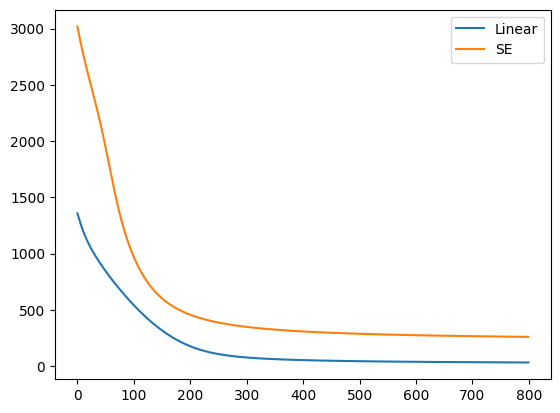

In [52]:
# initialize the kernel, likelihood, and model
pyro.clear_param_store()
kernel_L = gp.kernels.Linear(input_dim=X_train_t.size(1)) 
kernel_SE = gp.kernels.RBF(input_dim=X_train_t.size(1))


likelihood = gp.likelihoods.Gaussian()

# turn on "whiten" flag for more stable optimization
vsgp_L = VariationalGP(X_train_t, y_train_t, kernel_L, likelihood=likelihood, whiten=True)
vsgp_SE = VariationalGP(X_train_t, y_train_t, kernel_SE, likelihood=likelihood, whiten=True)

# instead of defining our own training loop, we will
# use the built-in support provided by the GP module
num_steps = 800
losses_L = gp.util.train(vsgp_L, num_steps=num_steps)
losses_SE = gp.util.train(vsgp_SE, num_steps=num_steps)
plt.figure()
plt.plot(losses_L, label='Linear')
plt.plot(losses_SE,label='SE')
plt.legend()
plt.show()

Predictions of the model, the associated error is also found.

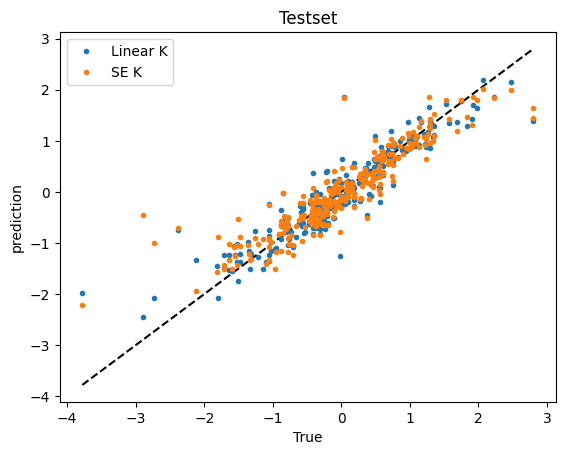

In [53]:
mean_L,cov = vsgp_L(X_test_t, full_cov=True)
mean_SE,cov = vsgp_SE(X_test_t, full_cov=True)
#std = cov.sqrt().diag()


# Plot
x = np.linspace(y_test.min(), y_test.max(), 2)
plt.figure()
plt.title('Testset')
plt.plot(x,x, 'k--')
plt.plot(y_test,mean_L.detach().numpy(), '.',label='Linear K')
plt.plot(y_test,mean_SE.detach().numpy(), '.',label='SE K')
plt.legend()
plt.xlabel('True')
plt.ylabel('prediction')
plt.show()

De-standardized plots

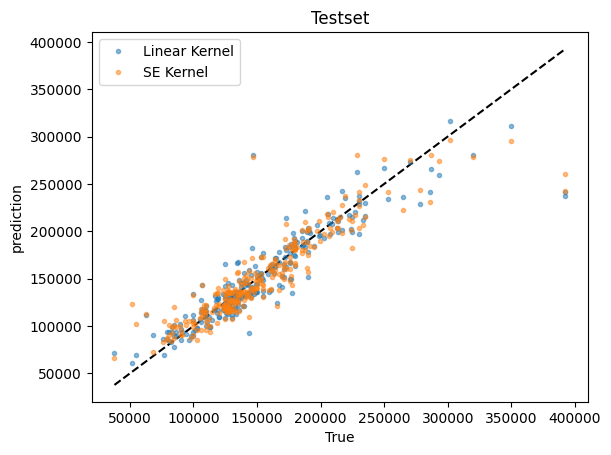

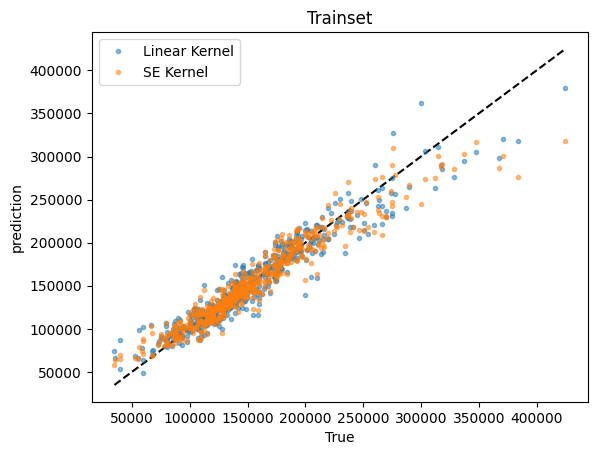

In [54]:
# Predict on train set
mean_L_train,_ = vsgp_L(X_train_t, full_cov=True)
mean_SE_train,_ = vsgp_SE(X_train_t, full_cov=True)

# Transforms
trans_true_test = transform(y_test, y_mean, y_std)
trans_true_train = transform(y_train, y_mean, y_std)
trans_preds_L_test = transform(mean_L.detach().numpy(), y_mean, y_std)
trans_preds_SE_test = transform(mean_SE.detach().numpy(), y_mean, y_std)
trans_preds_L_train = transform(mean_L_train.detach().numpy(), y_mean, y_std)
trans_preds_SE_train = transform(mean_SE_train.detach().numpy(), y_mean, y_std)


# Test
x = np.linspace(trans_true_test.min(), trans_true_test.max(), 2)
plt.figure()
plt.title('Testset')
plt.plot(x,x, 'k--')
plt.plot(trans_true_test,trans_preds_L_test, '.',label='Linear Kernel', alpha=0.5)
plt.plot(trans_true_test,trans_preds_SE_test, '.',label='SE Kernel', alpha=0.5)
plt.legend()
plt.xlabel('True')
plt.ylabel('prediction')
plt.show()


# Train
x = np.linspace(trans_true_train.min(), trans_true_train.max(), 2)
plt.figure()
plt.title('Trainset')
plt.plot(x,x, 'k--')
plt.plot(trans_true_train,trans_preds_L_train, '.',label='Linear Kernel', alpha=0.5)
plt.plot(trans_true_train,trans_preds_SE_train, '.',label='SE Kernel', alpha=0.5)
plt.legend()
plt.xlabel('True')
plt.ylabel('prediction')
plt.show()

Error meassures

In [57]:
trans_preds_L_train.shape

(560,)

In [61]:
## Error Linar kernel
corr_train, mae_train, rae_train, rmse_train, r2_train = compute_error(trans_true_train.ravel(), trans_preds_L_train.ravel())
corr_test, mae_test, rae_test, rmse_test, r2_test = compute_error(trans_true_test.ravel(), trans_preds_L_test.ravel())
print(f"Error with L kernel \ttrain \t\ttest\n\tCorrCoef: \t{corr_train:.3f} \t\t {corr_test:.3f} \n\tMAE:  \t\t{mae_train:.3f} \t{mae_test:.3f} \n\tRMSE:  \t\t{rmse_train:.3f} \t{rmse_test:.3f} \n\tR2:  \t\t{r2_train:.3f} \t\t{r2_test:.3f}")

# Error SE kernel
corr_train, mae_train, rae_train, rmse_train, r2_train  = compute_error(trans_true_train.ravel(), trans_preds_SE_train.ravel())
corr_test, mae_test, rae_test, rmse_test, r2_tes = compute_error(trans_true_test.ravel(), trans_preds_SE_test.ravel())
print(f"\nError with SE kernel \ttrain\t\ttest\n\tCorrCoef: \t{corr_train:.3f} \t\t {corr_test:.3f} \n\tMAE:  \t\t{mae_train:.3f} \t{mae_test:.3f} \n\tRMSE:  \t\t{rmse_train:.3f} \t{rmse_test:.3f} \n\tR2:  \t\t{r2_train:.3f} \t\t{r2_test:.3f}")

Error with L kernel 	train 		test
	CorrCoef: 	0.958 		 0.911 
	MAE:  		11473.565 	12870.184 
	RMSE:  		16056.576 	21596.906 
	R2:  		0.915 		0.828

Error with SE kernel 	train		test
	CorrCoef: 	0.962 		 0.912 
	MAE:  		10584.830 	13253.829 
	RMSE:  		15760.448 	21542.666 
	R2:  		0.918 		0.828


#### Model with selected parameters
The same method as but with fewer variables. The input X only consists of overall quality or GrLivArea.

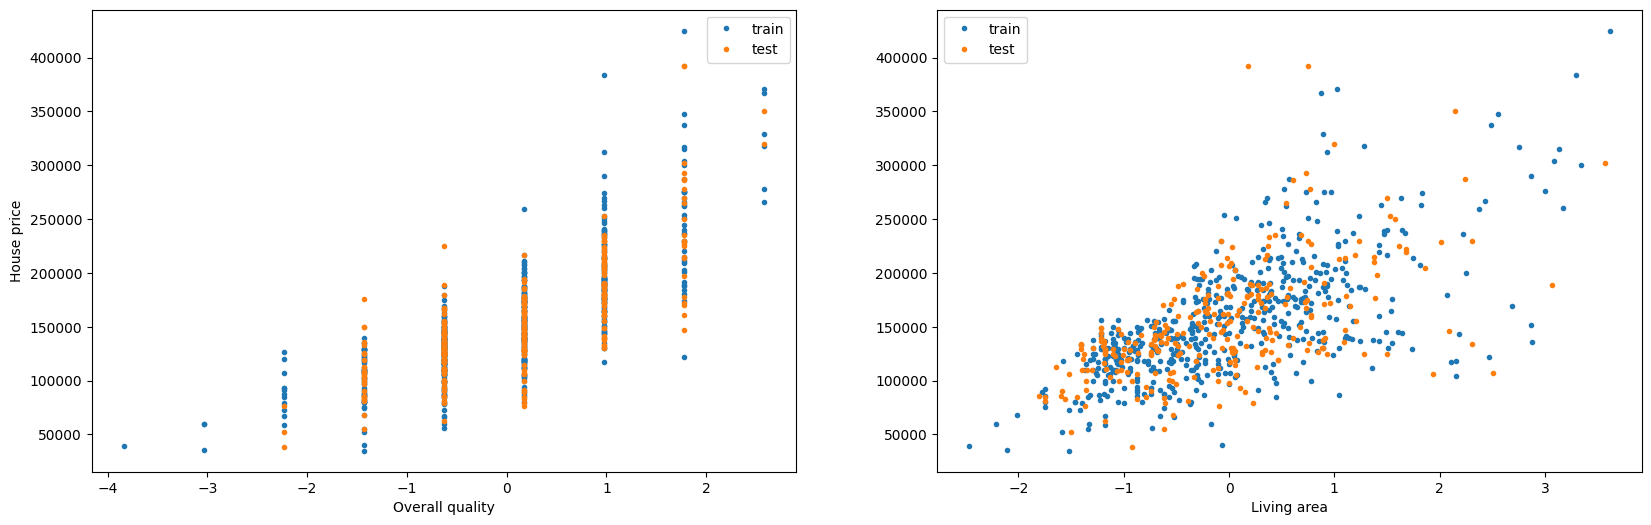

In [62]:
# Extract correct features
Xq_train = X_train_t[:,0]
Xq_test = X_test_t[:,0]
Xa_train = X_train_t[:,1]
Xa_test = X_test_t[:,1]

# plot
fig, axes = plt.subplots(1, 2, figsize=(20, 6))
axes[0].plot(Xq_train.numpy(),transform(y_train_t,y_mean,y_std),'.',label='train')
axes[0].plot(Xq_test.numpy(),transform(y_test_t,y_mean,y_std),'.',label='test')
axes[0].legend()
axes[0].set(xlabel='Overall quality', ylabel = 'House price');
axes[1].plot(Xa_train.numpy(),transform(y_train_t,y_mean,y_std),'.',label= 'train')
axes[1].plot(Xa_test.numpy(),transform(y_test_t,y_mean,y_std),'.',label='test')
axes[1].legend()
axes[1].set(xlabel='Living area');
plt.show()

Overall quality

In [63]:
# initialize the kernel, likelihood, and model
pyro.clear_param_store()
kernel_qSE = gp.kernels.RBF(input_dim=1)
kernel_qL = gp.kernels.Linear(input_dim=1)

likelihood_q = gp.likelihoods.Gaussian()

# turn on "whiten" flag for more stable optimization
vsgp_qL = VariationalGP(Xq_train, y_train_t, kernel_qL, likelihood=likelihood_q, whiten=True)
vsgp_qSE = VariationalGP(Xq_train, y_train_t, kernel_qSE, likelihood=likelihood_q, whiten=True)

# instead of defining our own training loop, we will
# use the built-in support provided by the GP module
num_steps = 400
lossesL = gp.util.train(vsgp_qL, num_steps=num_steps)
lossesSE = gp.util.train(vsgp_qSE, num_steps=num_steps)

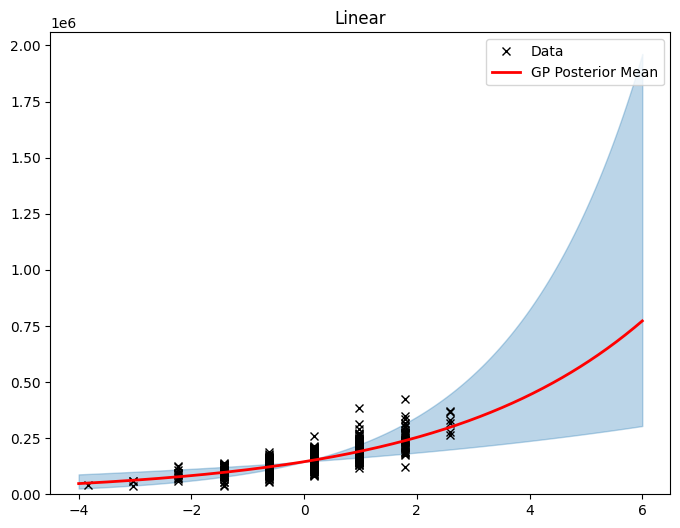

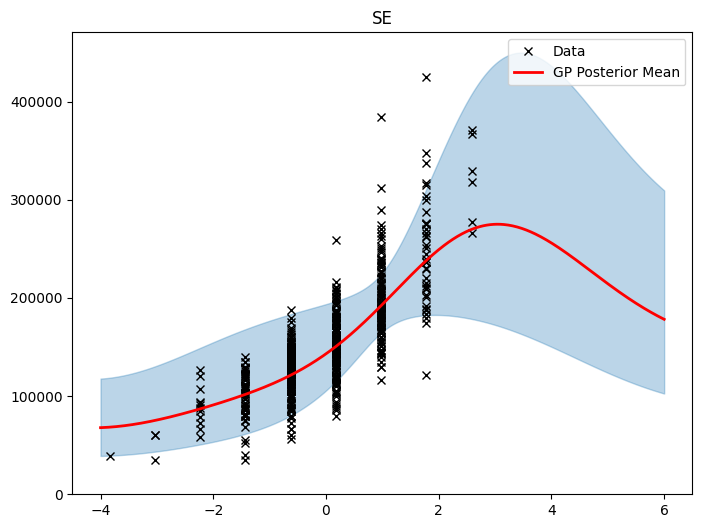

In [64]:
# Plots
plot(model=vsgp_qL, plot_observed_data=True,Xtest = Xq_test ,Xtrain = Xq_train, ytrain = y_train_t, plot_predictions=True, title='Linear')
plot(model=vsgp_qSE, plot_observed_data=True,Xtest = Xq_test ,Xtrain = Xq_train, ytrain = y_train_t, plot_predictions=True,title='SE')

In [66]:
type(transform(y_test_t, y_mean, y_std))

torch.Tensor

In [71]:
### Error

# Linear
predsL, covq = vsgp_qL(Xq_test, full_cov=True)
corr_test, mae_test, rae_test, rmse_test, r2_test= compute_error(transform(y_test_t, y_mean, y_std).numpy(), transform(predsL.detach().numpy(),y_mean, y_std))

predsL_train, covq = vsgp_qL(Xq_train, full_cov=True)
corr_train, mae_train, rae_train, rmse_train, r2_train= compute_error(transform(y_train_t, y_mean, y_std).numpy(), transform(predsL_train.detach().numpy(),y_mean, y_std))

print(f"Error with L kernel \ttrain \t\ttest\n\tCorrCoef: \t{corr_train:.3f} \t\t {corr_test:.3f} \n\tMAE:  \t\t{mae_train:.0f} \t\t{mae_test:.0f} \n\tRMSE:  \t\t{rmse_train:.0f} \t\t{rmse_test:.0f} \n\tR2:  \t\t{r2_train:.3f} \t\t{r2_test:.3f}")


# SE
predsSE, covq = vsgp_qSE(Xq_test, full_cov=True)
corr_test, mae_test, rae_test, rmse_test, r2_test= compute_error(transform(y_test_t, y_mean, y_std).numpy(), transform(predsSE.detach().numpy(),y_mean, y_std))

predsSE_train, covq = vsgp_qSE(Xq_train, full_cov=True)
corr_train, mae_train, rae_train, rmse_train, r2_train= compute_error(transform(y_train_t, y_mean, y_std).numpy(), transform(predsSE_train.detach().numpy(),y_mean, y_std))

print(f"\nError with SE kernel \ttrain \t\ttest\n\tCorrCoef: \t{corr_train:.3f} \t\t {corr_test:.3f} \n\tMAE:  \t\t{mae_train:.0f} \t\t{mae_test:.0f} \n\tRMSE:  \t\t{rmse_train:.0f} \t\t{rmse_test:.0f} \n\tR2:  \t\t{r2_train:.3f} \t\t{r2_test:.3f}")

Error with L kernel 	train 		test
	CorrCoef: 	0.804 		 0.781 
	MAE:  		24585 		23886 
	RMSE:  		33049 		32548 
	R2:  		0.641 		0.609

Error with SE kernel 	train 		test
	CorrCoef: 	0.801 		 0.776 
	MAE:  		24726 		24141 
	RMSE:  		33368 		32831 
	R2:  		0.634 		0.602


Ground living area

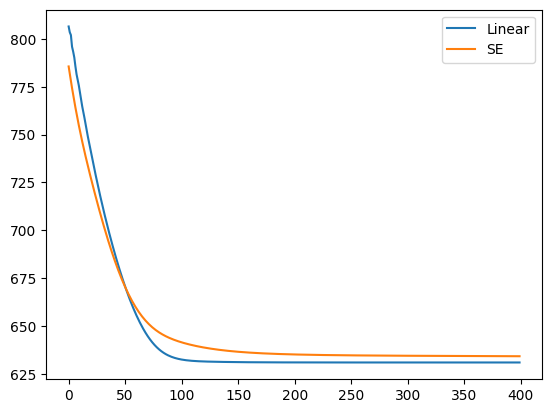

In [73]:
# initialize the kernel, likelihood, and model
pyro.clear_param_store()
kernel_aSE = gp.kernels.RBF(input_dim=1)
kernel_aL = gp.kernels.Linear(input_dim=1)

likelihood_a = gp.likelihoods.Gaussian()

# turn on "whiten" flag for more stable optimization
vsgp_aL = VariationalGP(Xa_train, y_train_t, kernel_aL, likelihood=likelihood_a, whiten=True)
vsgp_aSE = VariationalGP(Xa_train, y_train_t, kernel_aSE, likelihood=likelihood_a, whiten=True)

# instead of defining our own training loop, we will
# use the built-in support provided by the GP module
num_steps = 400
lossesL = gp.util.train(vsgp_aL, num_steps=num_steps)
lossesSE = gp.util.train(vsgp_aSE, num_steps=num_steps)
plt.plot(lossesL,label='Linear')
plt.plot(lossesSE, label='SE')
plt.legend()
plt.show()

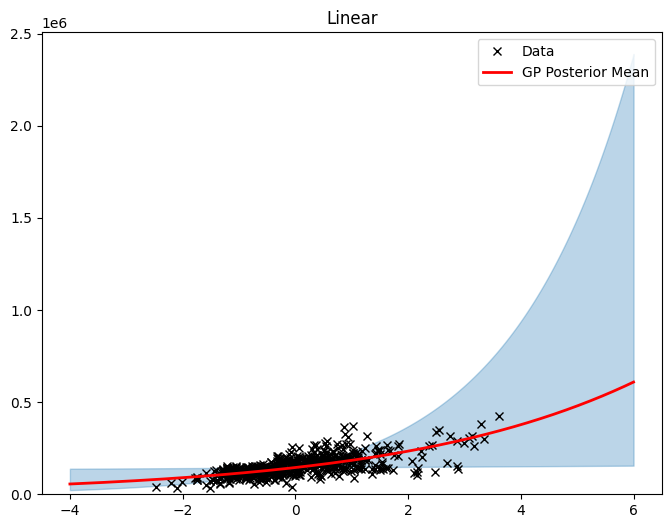

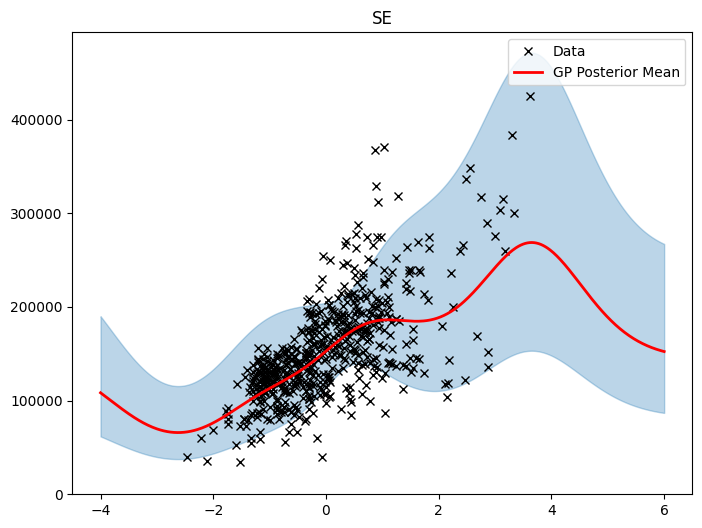

In [74]:
plot(model=vsgp_aL, plot_observed_data=True,Xtest = Xa_test ,Xtrain = Xa_train, ytrain = y_train_t, plot_predictions=True,title='Linear')
plot(model=vsgp_aSE, plot_observed_data=True,Xtest = Xa_test ,Xtrain = Xa_train, ytrain = y_train_t, plot_predictions=True,title='SE')

In [76]:
## Error

# Linear
predsL, covq = vsgp_qL(Xa_test, full_cov=True)
corr_test, mae_test, rae_test, rmse_test, r2_test= compute_error(transform(y_test_t, y_mean, y_std).numpy(), transform(predsL.detach().numpy(),y_mean, y_std))

predsL_train, covq = vsgp_qL(Xa_train, full_cov=True)
corr_train, mae_train, rae_train, rmse_train, r2_train= compute_error(transform(y_train_t, y_mean, y_std).numpy(), transform(predsL_train.detach().numpy(),y_mean, y_std))

print(f"Error with L kernel \ttrain \t\ttest\n\tCorrCoef: \t{corr_train:.3f} \t\t{corr_test:.3f} \n\tMAE:  \t\t{mae_train:.0f} \t\t{mae_test:.0f} \n\tRMSE:  \t\t{rmse_train:.0f} \t\t{rmse_test:.0f} \n\tR2:  \t\t{r2_train:.3f} \t\t{r2_test:.3f}")


# SE
predsSE, covq = vsgp_qSE(Xa_test, full_cov=True)
corr_test, mae_test, rae_test, rmse_test, r2_test= compute_error(transform(y_test_t, y_mean, y_std).numpy(), transform(predsSE.detach().numpy(),y_mean, y_std))

predsSE_train, covq = vsgp_qSE(Xa_train, full_cov=True)
corr_train, mae_train, rae_train, rmse_train, r2_train= compute_error(transform(y_train_t, y_mean, y_std).numpy(), transform(predsSE_train.detach().numpy(),y_mean, y_std))

print(f"\nError with SE kernel \ttrain \t\ttest\n\tCorrCoef: \t{corr_train:.3f} \t\t{corr_test:.3f} \n\tMAE:  \t\t{mae_train:.0f} \t\t{mae_test:.0f} \n\tRMSE:  \t\t{rmse_train:.0f} \t\t{rmse_test:.0f} \n\tR2:  \t\t{r2_train:.3f} \t\t{r2_test:.3f}")


Error with L kernel 	train 		test
	CorrCoef: 	0.655 		0.547 
	MAE:  		31757 		33379 
	RMSE:  		43685 		46368 
	R2:  		0.372 		0.205

Error with SE kernel 	train 		test
	CorrCoef: 	0.595 		0.532 
	MAE:  		40705 		41877 
	RMSE:  		52265 		53906 
	R2:  		0.101 		0.000
